# UKB OMOP EDA 

Using omop databases

Drugs for this study: loperamide, methadone,fentanyl, morphine, sufentanil.
Sufentanil does not appear in the omop database(after searching in the drug_era_atc.tsv).

In [1]:
!pip install upsetplot
!pip install scikit-learn

In [101]:
import pyspark
import dxpy
import dxdata
from pyspark.sql.functions import col, to_date, lower

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from upsetplot import UpSet
from sklearn.preprocessing import StandardScaler

First obtain the drug id with drug_era_atc.tsv table and the atc_dict.py to obtain the ATC of each drug.

In [ ]:
# Load the table
df = pd.read_csv("mappings/drug_era/drug_era_atc.tsv", sep="\t")

# List of drugs to filter
drugs_to_filter = ["loperamide", "methadone", "fentanyl", "morphine"]

# Filter rows where the drug name is in the list of drugs to filter
filtered_df = df[df["concept_name"].isin(drugs_to_filter)]

# Select the required columns and rename _c13 to ATC
filtered_df = filtered_df[
    [
        "drug_concept_id",
        "concept_name",
        "domain_id",
        "concept_class_id",
        "concept_code",
        "valid_start_date",
        "valid_end_date",
        "invalid_reason",
        "_c13",
    ]
]

# Rename the _c13 column to ATC
filtered_df.rename(columns={"_c13": "ATC"}, inplace=True)

filtered_df

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03
1413,1110410,morphine,Drug,Ingredient,7052,1970-01-01,2099-12-31,NaN,N02AA01


In [ ]:
# Import the ATC dictionaries from atc_dict.py (look in which directory it is located)
from atc_dict import atc_first_level_full_list, atc_second_level_full_list

# Map first level ATC codes
filtered_df["ATC_First_Level"] = filtered_df["ATC"].apply(
    lambda x: x[0] if isinstance(x, str) else None
)
filtered_df["ATC_Second_Level"] = filtered_df["ATC"].apply(
    lambda x: x[:3] if isinstance(x, str) else None
)

# Map the names of the first and second level ATC categories using the imported dictionaries
filtered_df["First_Level_Name"] = filtered_df["ATC_First_Level"].map(
    atc_first_level_full_list
)
filtered_df["Second_Level_Name"] = filtered_df["ATC_Second_Level"].map(
    lambda x: atc_second_level_full_list.get(x[0], {}).get(x, "Unknown")
)

filtered_df

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC,ATC_First_Level,ATC_Second_Level,First_Level_Name,Second_Level_Name
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01,N,N01,Nervous System,Anesthetics
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03,N,N02,Nervous System,Analgesics
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02,N,N07,Nervous System,Other Nervous System Drugs
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."
1413,1110410,morphine,Drug,Ingredient,7052,1970-01-01,2099-12-31,NaN,N02AA01,N,N02,Nervous System,Analgesics


In [5]:
# Save the filtered table to a new file
filtered_df.to_csv("filtered_drug_atc.tsv", sep="\t", index=False)

Now we can obtain the omop data bases from UK Biobank and filter for the drugs ids of interest

In [6]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [7]:
# Init pyspark and load dataframe
# Load the 'omop_drug_era' 'omop_drug_exposure' and 'omop_person' tables
omop_drug_era = "omop_drug_era"
omop_drug_exposure = "omop_drug_exposure"
omop_person = "omop_person"
# Load tables
drug_era = dataset[omop_drug_era]
drug_exposure = dataset[omop_drug_exposure]
person = dataset[omop_person]

# Extract all field names from the tables
field_names_era = [f.name for f in drug_era.fields]
field_names_exposure = [f.name for f in drug_exposure.fields]
field_names_person = [f.name for f in person.fields]

# Retrieve the fields
df_era = drug_era.retrieve_fields(names=field_names_era, engine=dxdata.connect())
df_exposure = drug_exposure.retrieve_fields(
    names=field_names_exposure, engine=dxdata.connect()
)
df_person = person.retrieve_fields(names=field_names_person, engine=dxdata.connect())

print(df_era.columns)
print(df_exposure.columns)
print(df_person.columns)

print(f"Number of entries era {df_era.count()}")
print(f"Number of entries exposure {df_exposure.count()}")
print(f"Number of entries person {df_person.count()}")
df_era.drop("eid").show(3, truncate=False)
df_exposure.drop("eid").show(3, truncate=False)
df_person.drop("eid").show(3, truncate=False)

['eid', 'drug_era_id', 'drug_concept_id', 'drug_era_start_date', 'drug_era_end_date', 'drug_exposure_count', 'gap_days']
['eid', 'drug_exposure_id', 'drug_concept_id', 'drug_exposure_start_date', 'drug_exposure_start_datetime', 'drug_exposure_end_date', 'drug_exposure_end_datetime', 'verbatim_end_date', 'drug_type_concept_id', 'stop_reason', 'refills', 'quantity', 'days_supply', 'sig', 'route_concept_id', 'lot_number', 'provider_id', 'visit_occurrence_id', 'visit_detail_id', 'drug_source_value', 'drug_source_concept_id', 'route_source_value', 'dose_unit_source_value']
['eid', 'gender_concept_id', 'year_of_birth', 'month_of_birth', 'day_of_birth', 'birth_datetime', 'race_concept_id', 'ethnicity_concept_id', 'location_id', 'provider_id', 'care_site_id', 'person_source_value', 'gender_source_value', 'gender_source_concept_id', 'race_source_value', 'race_source_concept_id', 'ethnicity_source_value', 'ethnicity_source_concept_id']
Number of entries era 19959413
Number of entries exposure 55

In [8]:
# Load the `filtered_drug_atc.tsv` file as a Pandas DataFrame
drug_mapping_df = pd.read_csv("filtered_drug_atc.tsv", sep="\t")
# Extract `drug_concept_id` values as a list
drug_concept_ids = drug_mapping_df["drug_concept_id"].dropna().unique().tolist()
drug_concept_ids

[1154029, 1103640, 991876, 1110410]

In [9]:
# Filter the OMOP dataset for relevant drug_concept_id
filtered_df_era = df_era.filter(col("drug_concept_id").isin(drug_concept_ids))
# Format date columns
filtered_df_era = filtered_df_era.withColumn(
    "drug_era_start_date", to_date(col("drug_era_start_date"), "dd/MM/yyyy")
).withColumn("drug_era_end_date", to_date(col("drug_era_end_date"), "dd/MM/yyyy"))

# Merge with person_df on the 'eid' column to keep information about the person
# Select only the required columns from df_person
df_person_selected = df_person.select("eid", "gender_concept_id", "year_of_birth")

# Perform a left join with filtered_df_era on the 'eid' column
filtered_df_era = filtered_df_era.join(
    df_person_selected,
    on="eid",
    how="left",  # Perform a left join
)
# Show the result of the filter
filtered_df_era.drop("eid").show(truncate=False)
filtered_df_era.count()

+-------------+---------------+-------------------+-----------------+-------------------+--------+-----------------+-------------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|gender_concept_id|year_of_birth|
+-------------+---------------+-------------------+-----------------+-------------------+--------+-----------------+-------------+
|730144538282 |1110410        |2009-09-21         |2009-10-27       |2                  |0       |8532             |1951         |
|1176821107656|991876         |2014-07-28         |2014-08-08       |1                  |0       |8532             |1949         |
|17179961333  |991876         |2007-02-13         |2007-03-14       |1                  |0       |8507             |1954         |
|1400159383219|991876         |2011-06-03         |2011-07-27       |2                  |0       |8532             |1959         |
|1700807107514|991876         |2007-11-07         |2007-11-12       |1             

72395

In [10]:
# Filter the OMOP drug exposure dataset for morphine: Filter the rows that drug_source_value contain the drug name (case insensitive search)
# Use regular expression to match only the exact word 'morphine' and avoid partial matches
filtered_df_exposure_morphine = df_exposure.filter(lower(df_exposure["drug_source_value"]).rlike(r"\b" + "morphine" + r"\b"))
# Check if the filtered DataFrame is empty
if filtered_df_exposure_morphine.count() > 0:
    print(f"Rows containing morphine:")
    print(filtered_df_exposure_morphine.count())
    # Format the date columns (if necessary)
    filtered_df_exposure_morphine = filtered_df_exposure_morphine.withColumn(
    "drug_exposure_start_date", to_date(col("drug_exposure_start_date"), "dd/MM/yyyy")).withColumn(
    "drug_exposure_end_date", to_date(col("drug_exposure_end_date"), "dd/MM/yyyy"))
    
    filtered_df_exposure_morphine.drop("eid").show(truncate=False)
else:
    print(f"The drug morphine does not appear in this dataset.")

# Define the relevant columns for EDA
relevant_columns = [
    "eid",
    "drug_concept_id",
    "drug_exposure_start_date",
    "drug_exposure_end_date",
    "stop_reason",
    "refills",
    "days_supply",  # you can keep this to analyze duration or adherence
    "quantity",  # optional, can help to understand quantity per exposure
    "drug_source_value"
]

# Filter out the columns that are relevant for the EDA
filtered_df_exposure_morphine = filtered_df_exposure_morphine.select(relevant_columns)


# Merge with person_df on the 'eid' column to keep information about the person
# Perform a left join with filtered_df_exposure on the 'eid' column
filtered_df_exposure_morphine = filtered_df_exposure_morphine.join(
    df_person_selected,
    on="eid",
    how="left",  # Perform a left join
)
# Show the result of the filter
filtered_df_exposure_morphine.drop("eid").show(truncate=False)
filtered_df_exposure_morphine.count()

Rows containing morphine:
31813
+----------------+---------------+------------------------+----------------------------+----------------------+--------------------------+-----------------+--------------------+-----------+-------+--------+-----------+----+----------------+----------+-----------+-------------------+---------------+---------------------------------------------------------+----------------------+------------------+----------------------+
|drug_exposure_id|drug_concept_id|drug_exposure_start_date|drug_exposure_start_datetime|drug_exposure_end_date|drug_exposure_end_datetime|verbatim_end_date|drug_type_concept_id|stop_reason|refills|quantity|days_supply|sig |route_concept_id|lot_number|provider_id|visit_occurrence_id|visit_detail_id|drug_source_value                                        |drug_source_concept_id|route_source_value|dose_unit_source_value|
+----------------+---------------+------------------------+----------------------------+----------------------+-----------

31813

From gp_scripts there was 35396, is a similar number (the difference could be because the gp_scripts is always actualizing)

We get the concept data base to see to what corresponds the  gender_concept_id, from here you can also get other ids if needed.

In [11]:
 !wget  -nd  biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/omop_concept.tsv

--2024-12-08 15:17:02--  http://biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/omop_concept.tsv
Resolving biobank.ndph.ox.ac.uk (biobank.ndph.ox.ac.uk)... 163.1.206.99
Connecting to biobank.ndph.ox.ac.uk (biobank.ndph.ox.ac.uk)|163.1.206.99|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/omop_concept.tsv [following]
--2024-12-08 15:17:02--  https://biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/omop_concept.tsv
Connecting to biobank.ndph.ox.ac.uk (biobank.ndph.ox.ac.uk)|163.1.206.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1134726154 (1.1G) [text/tab-separated-values]
Saving to: ‘omop_concept.tsv.1’

omop_concept.tsv.1  100%[===================>]   1.06G   125MB/s    in 8.5s    

2024-12-08 15:17:10 (127 MB/s) - ‘omop_concept.tsv.1’ saved [1134726154/1134726154]



In [12]:
# Convert the filtered Spark DataFrame to a Pandas DataFrame
pandas_df_era = filtered_df_era.toPandas()
pandas_df_era.loc[:, "drug_concept_id"] = pandas_df_era.loc[
    :, "drug_concept_id"
].astype(int)
# Merge pandas_df_era with drug_mapping_df on `drug_concept_id`
pandas_df_era = pandas_df_era.merge(
    drug_mapping_df[["drug_concept_id", "concept_name"]],  # Only keep necessary columns
    on="drug_concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'drug'
pandas_df_era.rename(columns={"concept_name": "drug"}, inplace=True)
# Read the omop_concept.tsv table
omop_concept_df = pd.read_csv("omop_concept.tsv", sep="\t")
# Ensure both columns have the same data type
pandas_df_era.loc[:, "gender_concept_id"] = pandas_df_era.loc[
    :, "gender_concept_id"
].astype(int)

# Merge dataframes on the appropriate columns
pandas_df_era = pandas_df_era.merge(
    omop_concept_df[["concept_id", "concept_name"]],
    left_on="gender_concept_id",
    right_on="concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'gender'
pandas_df_era.rename(columns={"concept_name": "gender"}, inplace=True)
# Drop the extra 'concept_id' column, if not needed
pandas_df_era.drop(columns="concept_id", inplace=True)

# Save the Pandas DataFrame to a CSV file
pandas_df_era.to_csv("filtered_data_era.csv", index=False)

/tmp/ipykernel_570/3978559317.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pandas_df_era.loc[:, "drug_concept_id"] = pandas_df_era.loc[
/tmp/ipykernel_570/3978559317.py:15: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  omop_concept_df = pd.read_csv("omop_concept.tsv", sep="\t")
/tmp/ipykernel_570/3978559317.py:17: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pandas_df_era.loc[:, "gender_concept_id"] = pandas_df_era.loc[


In [13]:
display(pandas_df_era.drop("eid", axis=1))

,drug_era_id,drug_concept_id,drug_era_start_date,drug_era_end_date,drug_exposure_count,gap_days,gender_concept_id,year_of_birth,drug,gender
0,730144538282,1110410,2009-09-21,2009-10-27,2,0,8532,1951,morphine,FEMALE
1,1176821107656,991876,2014-07-28,2014-08-08,1,0,8532,1949,loperamide,FEMALE
2,17179961333,991876,2007-02-13,2007-03-14,1,0,8507,1954,loperamide,MALE
3,1400159383219,991876,2011-06-03,2011-07-27,2,0,8532,1959,loperamide,FEMALE
4,1700807107514,991876,2007-11-07,2007-11-12,1,0,8532,1945,loperamide,FEMALE
...,...,...,...,...,...,...,...,...,...,...
75517,601295453580,991876,2009-12-24,2010-01-12,1,0,8507,1944,loperamide,MALE
75518,618475340648,991876,2005-11-24,2005-11-29,1,0,8507,1965,loperamide,MALE
75519,1554778227782,991876,2000-03-13,2000-03-18,1,0,8507,1957,loperamide,MALE
75520,1571958032822,991876,2002-12-05,2003-06-10,7,152,8532,1951,loperamide,FEMALE


In [14]:
pandas_df_exposure_morphine = filtered_df_exposure_morphine.toPandas()
pandas_df_exposure_morphine["drug_name"] = "morphine"
# Ensure both columns have the same data type
pandas_df_exposure_morphine.loc[:, "gender_concept_id"] = pandas_df_exposure_morphine.loc[
    :, "gender_concept_id"
].astype(int)

# Merge dataframes on the appropriate columns
pandas_df_exposure_morphine = pandas_df_exposure_morphine.merge(
    omop_concept_df[["concept_id", "concept_name"]],
    left_on="gender_concept_id",
    right_on="concept_id",
    how="left",
)
# Rename the 'concept_name' column to 'gender'
pandas_df_exposure_morphine.rename(columns={"concept_name": "gender"}, inplace=True)
# Drop the extra 'concept_id' column, if not needed
pandas_df_exposure_morphine.drop(columns="concept_id", inplace=True)

# Save the Pandas DataFrame to a CSV file
pandas_df_exposure_morphine.to_csv("filtered_data_exposure_morphine.csv", index=False)

/tmp/ipykernel_570/3029625227.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  pandas_df_exposure_morphine.loc[:, "gender_concept_id"] = pandas_df_exposure_morphine.loc[


In [15]:
display(pandas_df_exposure_morphine.drop("eid", axis=1))

,drug_concept_id,drug_exposure_start_date,drug_exposure_end_date,stop_reason,refills,days_supply,quantity,drug_source_value,gender_concept_id,year_of_birth,drug_name,gender
0,40169894,2009-08-03,2009-08-08,None,None,None,56,Morphine Sulphate TABS 10MG,8532,1954,morphine,FEMALE
1,40169894,2015-12-16,2015-12-21,None,None,None,56,Morphine Sulfate Tablets 10 mg,8532,1938,morphine,FEMALE
2,40169944,2015-06-29,2015-07-28,None,None,None,100,Morphine sulfate 10mg/5ml oral solution,8532,1967,morphine,FEMALE
3,40169944,2011-01-18,2011-02-16,None,None,None,1,Morphine sulfate 10mg/5ml oral solution,8532,1962,morphine,FEMALE
4,40169944,2010-11-08,2010-12-07,None,None,None,1,Morphine sulfate 10mg/5ml oral solution,8532,1962,morphine,FEMALE
...,...,...,...,...,...,...,...,...,...,...,...,...
31808,40169893,2014-04-11,2014-04-16,None,None,None,60,Morphine 10mg modified-release tablets,8507,1956,morphine,MALE
31809,40170056,2013-08-08,2013-09-12,None,None,None,60,Morphine 60mg modified-release tablets,8507,1956,morphine,MALE
31810,43734654,2011-09-06,2011-10-05,None,None,None,5,Morphine sulfate 10mg/1ml solution for injecti...,8507,1943,morphine,MALE
31811,40169944,2006-07-28,2006-08-26,None,None,None,200,Morphine sulfate 10mg/5ml oral solution,8532,1939,morphine,FEMALE


## OMOP era EDA Figures and analysis

Analyse omop era and not exposure because it contains much more data (omop exposure has only 21 rows)

In [16]:
# Load the CSV file as a DataFrame
data = pd.read_csv("filtered_data_era.csv")

         drug  count
1  loperamide  15660
3    morphine   7217
0    fentanyl   1684
2   methadone     82


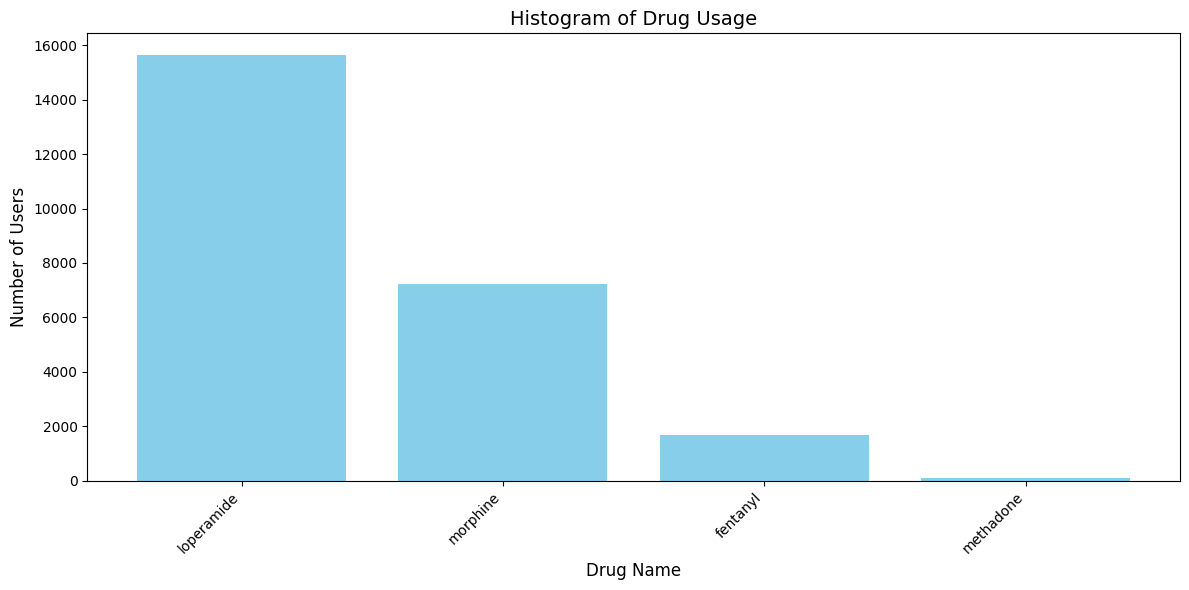

In [17]:
# Create the histogram
plt.figure(figsize=(12, 6))
eid_counts = data.groupby(["eid", "drug"]).size().reset_index(name="count")
drug_counts = eid_counts.groupby("drug").size().reset_index(name="count")
# Sort for better visualization
drug_counts = drug_counts.sort_values(by="count", ascending=False)
print(drug_counts)
# Sort for better visualization
drug_counts = drug_counts.sort_values(by="count", ascending=False)

plt.bar(drug_counts["drug"], drug_counts["count"], color="skyblue")
plt.xlabel("Drug Name", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.title("Histogram of Drug Usage", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()

# Save the plot as an image file
plt.savefig("drug_usage_histogram.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

         drug  drug_exposure_count
3    morphine               113566
1  loperamide               106541
0    fentanyl                73888
2   methadone                 3181


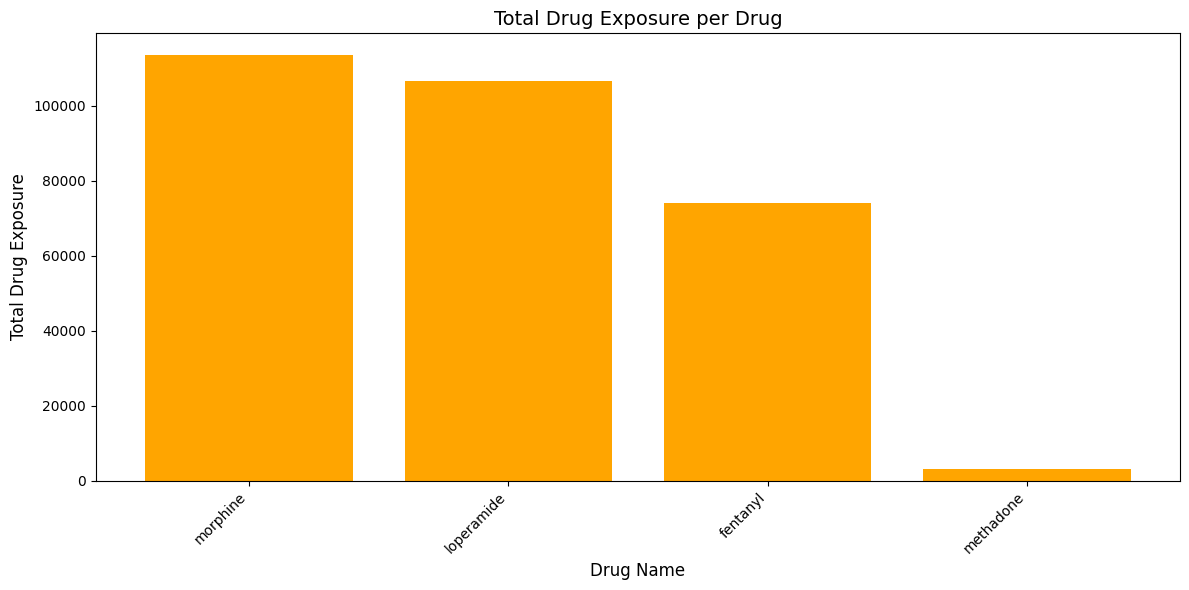

In [18]:
# Create the histogram for total drug_exposure_count
plt.figure(figsize=(12, 6))
drug_exposure_totals = data.groupby("drug")["drug_exposure_count"].sum().reset_index()

# Sort for better visualization
drug_exposure_totals = drug_exposure_totals.sort_values(
    by="drug_exposure_count", ascending=False
)
print(drug_exposure_totals)
plt.bar(
    drug_exposure_totals["drug"],
    drug_exposure_totals["drug_exposure_count"],
    color="orange",
)
plt.xlabel("Drug Name", fontsize=12)
plt.ylabel("Total Drug Exposure", fontsize=12)
plt.title("Total Drug Exposure per Drug", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()

# Save the plot as an image file
plt.savefig("total_drug_exposure_histogram.svg", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

<Figure size 1200x800 with 0 Axes>

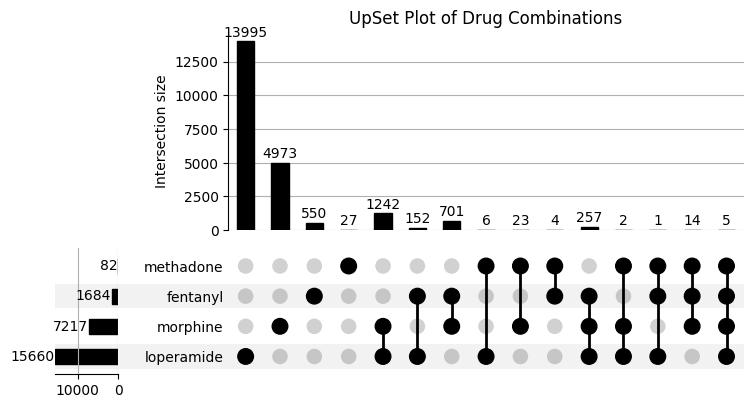

In [19]:
# Upset plot
# Create a set of drug combinations per person (eid)
# Create sets for each drug
loperamide_set = set(data[data["drug"] == "loperamide"]["eid"].unique())
methadone_set = set(data[data["drug"] == "methadone"]["eid"].unique())
fentanyl_set = set(data[data["drug"] == "fentanyl"]["eid"].unique())
morphine_set = set(data[data["drug"] == "morphine"]["eid"].unique())

# Combine all the sets to get a list of unique 'eid's
all_eids = list(loperamide_set.union(methadone_set, fentanyl_set, morphine_set))

# Now, create a binary DataFrame where each row represents an `eid` and each column is a drug
binary_data = {
    "loperamide": [1 if eid in loperamide_set else 0 for eid in all_eids],
    "methadone": [1 if eid in methadone_set else 0 for eid in all_eids],
    "fentanyl": [1 if eid in fentanyl_set else 0 for eid in all_eids],
    "morphine": [1 if eid in morphine_set else 0 for eid in all_eids],
}

# Create a DataFrame from the binary data
drug_combinations = pd.DataFrame(binary_data, index=all_eids)

# Use the UpSetPlot package to visualize the drug combinations
upset_data = drug_combinations.groupby(list(binary_data.keys())).size()

# Create the UpSet plot
upset = UpSet(upset_data, show_counts=True, show_percentages=False)
plt.figure(figsize=(12, 8))
upset.plot()
plt.title("UpSet Plot of Drug Combinations")

# Save the plot as an image file
plt.savefig("upset_plot_drug_combinations.svg", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

Now I will continue an anylisis of Morphine specifically

In [20]:
data_morphine = data[data["drug"] == "morphine"]

   gender  count
0  FEMALE   3907
1    MALE   3310


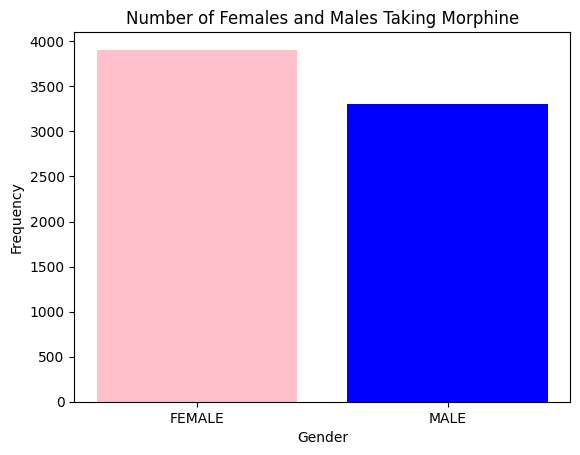

In [21]:
# Histogram of genders
eid_gender_counts = (
    data_morphine.groupby(["eid", "gender"]).size().reset_index(name="count")
)
gender_counts = eid_gender_counts.groupby("gender").size().reset_index(name="count")
print(gender_counts)
plt.bar(gender_counts["gender"], gender_counts["count"], color=["pink", "blue"])
plt.title("Number of Females and Males Taking Morphine")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.savefig("gender_histogram_morphine.png", dpi=300, bbox_inches="tight")
plt.show()

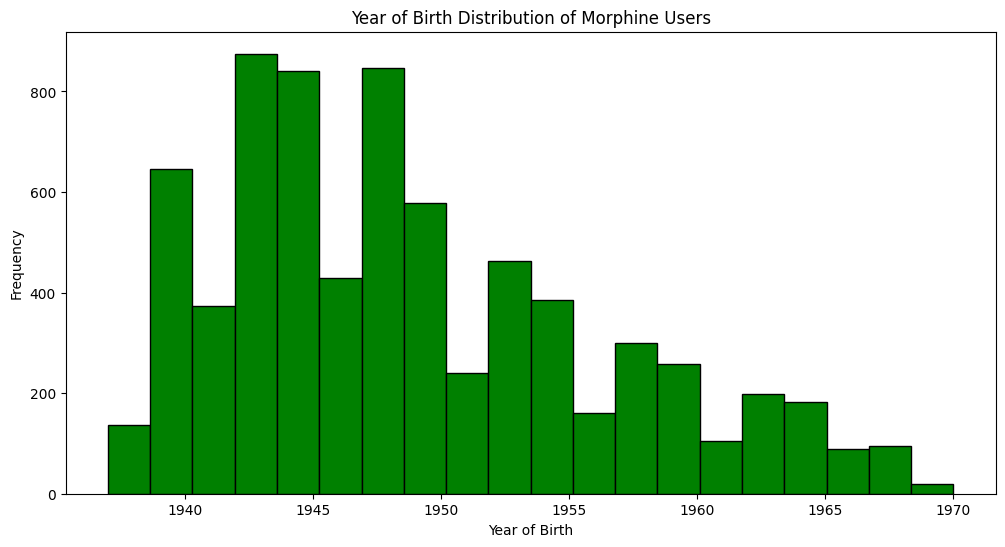

In [22]:
# Histogram of year of birth
eid_year_counts = (
    data_morphine.groupby(["eid", "year_of_birth"]).size().reset_index(name="count")
)
plt.figure(figsize=(12, 6))
plt.hist(eid_year_counts["year_of_birth"], bins=20, color="green", edgecolor="black")
plt.title("Year of Birth Distribution of Morphine Users")
plt.xlabel("Year of Birth")
plt.ylabel("Frequency")
plt.savefig("age_histogram_morphine.png", dpi=300, bbox_inches="tight")
plt.show()

In [23]:
data_morphine_sorted = data_morphine.sort_values(by="drug_era_start_date")
morphine_eras_count = (
    data_morphine_sorted.groupby("eid")
    .agg(
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(morphine_eras_count.drop("eid", axis=1))

,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days
0,1,[2013-02-06],[2013-03-12],[2],[0]
1,1,[2008-07-31],[2008-08-11],[1],[0]
2,1,[2013-04-08],[2014-04-05],[51],[37]
3,1,[2015-05-07],[2015-06-16],[4],[0]
4,1,[2015-09-11],[2015-10-17],[2],[0]
...,...,...,...,...,...
7212,4,"[2013-03-01, 2013-12-12, 2014-09-22, 2015-01-30]","[2013-03-30, 2014-01-10, 2014-10-21, 2015-06-26]","[1, 1, 2, 10]","[0, 0, 7, 27]"
7213,2,"[2010-05-14, 2013-01-15]","[2010-09-11, 2013-02-13]","[4, 1]","[19, 0]"
7214,1,[2003-08-05],[2003-10-24],[3],[7]
7215,1,[2013-11-25],[2016-07-12],[49],[253]


In [24]:
# Analyze num_drug_era_id
print("Summary of num_drug_era_id:")
print(morphine_eras_count["num_drug_era_id"].describe())

# Total exposures per participant
morphine_eras_count["total_exposure_counts"] = morphine_eras_count[
    "exposure_counts"
].apply(sum)
# Analyze total exposure counts
print("\nSummary of total exposure:")
print(morphine_eras_count["total_exposure_counts"].describe())

# Calculate the standard deviation of exposure_counts to assess variability:
morphine_eras_count["exposure_counts_std"] = morphine_eras_count[
    "exposure_counts"
].apply(lambda x: np.nanstd(x))
# Analyze total exposure counts
print("\nSummary of exposure counts std:")
print(morphine_eras_count["exposure_counts_std"].describe())

# Convert dates to datetime
morphine_eras_count['start_dates_parsed'] = morphine_eras_count['start_dates'].apply(lambda x: pd.to_datetime(x))
morphine_eras_count['end_dates_parsed'] = morphine_eras_count['end_dates'].apply(lambda x: pd.to_datetime(x))
# Calculate total_duration
morphine_eras_count['total_duration'] = morphine_eras_count.apply(lambda row: (max(row['end_dates_parsed']) - min(row['start_dates_parsed'])).days, axis=1)
print("Summary of total_duration:")
print(morphine_eras_count["total_duration"].describe())

# Calculate duration_era
morphine_eras_count['duration_era'] = morphine_eras_count.apply(lambda row: [(end - start).days for start, end in zip(row['start_dates_parsed'], row['end_dates_parsed'])], axis=1)

# Calculate gap_between_eras
morphine_eras_count['gap_between_eras'] = morphine_eras_count.apply(
    lambda row: [(next_start - prev_end).days for prev_end, next_start in zip(row['end_dates_parsed'][:-1], row['start_dates_parsed'][1:])], 
    axis=1
)
# Average gap days per participant (ignoring NaN gaps)
morphine_eras_count["average_gap_days"] = morphine_eras_count["gap_days"].apply(
    lambda x: np.nanmean(x)
)  # Exclude NaN
print("\nSummary of average_gap_days:")
print(morphine_eras_count["average_gap_days"].describe())

# Average gap days between eras per participant (ignoring NaN gaps)
morphine_eras_count["average_gap_days_between_eras"] = morphine_eras_count["gap_between_eras"].apply(
    lambda x: np.nanmean(x)
)  # Exclude NaN
print("\nSummary of average_gap_days_between_eras:")
print(morphine_eras_count["average_gap_days_between_eras"].describe())

display(morphine_eras_count.drop("eid", axis=1))

Summary of num_drug_era_id:
count    7217.000000
mean        2.077872
std         3.451562
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        80.000000
Name: num_drug_era_id, dtype: float64

Summary of total exposure:
count    7217.000000
mean       15.735901
std        44.949850
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max      1004.000000
Name: total_exposure_counts, dtype: float64

Summary of exposure counts std:
count    7217.000000
mean        2.282553
std        10.368328
min         0.000000
25%         0.000000
50%         0.000000
75%         0.400000
max       230.000000
Name: exposure_counts_std, dtype: float64
Summary of total_duration:
count    7217.000000
mean      476.932520
std       981.655779
min         0.000000
25%        29.000000
50%        56.000000
75%       363.000000
max      9621.000000
Name: total_duration, dtype: float64

Summary of average_gap_days:
count    7217.000000


/tmp/ipykernel_570/2230826667.py:46: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x)


,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,exposure_counts_std,start_dates_parsed,end_dates_parsed,total_duration,duration_era,gap_between_eras,average_gap_days,average_gap_days_between_eras
0,1,[2013-02-06],[2013-03-12],[2],[0],2,0.000000,"DatetimeIndex(['2013-02-06'], dtype='datetime6...","DatetimeIndex(['2013-03-12'], dtype='datetime6...",34,[34],[],0.0,NaN
1,1,[2008-07-31],[2008-08-11],[1],[0],1,0.000000,"DatetimeIndex(['2008-07-31'], dtype='datetime6...","DatetimeIndex(['2008-08-11'], dtype='datetime6...",11,[11],[],0.0,NaN
2,1,[2013-04-08],[2014-04-05],[51],[37],51,0.000000,"DatetimeIndex(['2013-04-08'], dtype='datetime6...","DatetimeIndex(['2014-04-05'], dtype='datetime6...",362,[362],[],37.0,NaN
3,1,[2015-05-07],[2015-06-16],[4],[0],4,0.000000,"DatetimeIndex(['2015-05-07'], dtype='datetime6...","DatetimeIndex(['2015-06-16'], dtype='datetime6...",40,[40],[],0.0,NaN
4,1,[2015-09-11],[2015-10-17],[2],[0],2,0.000000,"DatetimeIndex(['2015-09-11'], dtype='datetime6...","DatetimeIndex(['2015-10-17'], dtype='datetime6...",36,[36],[],0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7212,4,"[2013-03-01, 2013-12-12, 2014-09-22, 2015-01-30]","[2013-03-30, 2014-01-10, 2014-10-21, 2015-06-26]","[1, 1, 2, 10]","[0, 0, 7, 27]",14,3.774917,"DatetimeIndex(['2013-03-01', '2013-12-12', '20...","DatetimeIndex(['2013-03-30', '2014-01-10', '20...",847,"[29, 29, 29, 147]","[257, 255, 101]",8.5,204.333333
7213,2,"[2010-05-14, 2013-01-15]","[2010-09-11, 2013-02-13]","[4, 1]","[19, 0]",5,1.500000,"DatetimeIndex(['2010-05-14', '2013-01-15'], dt...","DatetimeIndex(['2010-09-11', '2013-02-13'], dt...",1006,"[120, 29]",[857],9.5,857.000000
7214,1,[2003-08-05],[2003-10-24],[3],[7],3,0.000000,"DatetimeIndex(['2003-08-05'], dtype='datetime6...","DatetimeIndex(['2003-10-24'], dtype='datetime6...",80,[80],[],7.0,NaN
7215,1,[2013-11-25],[2016-07-12],[49],[253],49,0.000000,"DatetimeIndex(['2013-11-25'], dtype='datetime6...","DatetimeIndex(['2016-07-12'], dtype='datetime6...",960,[960],[],253.0,NaN


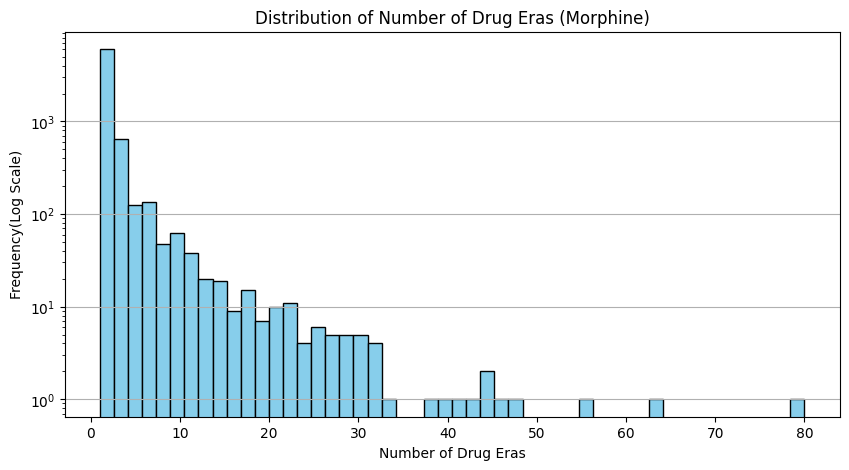

In [25]:
# Visualize num_drug_era_id
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count["num_drug_era_id"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Drug Eras (Morphine)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.savefig("distribution_number_eras_morphine.svg", dpi=300, bbox_inches="tight")
plt.show()

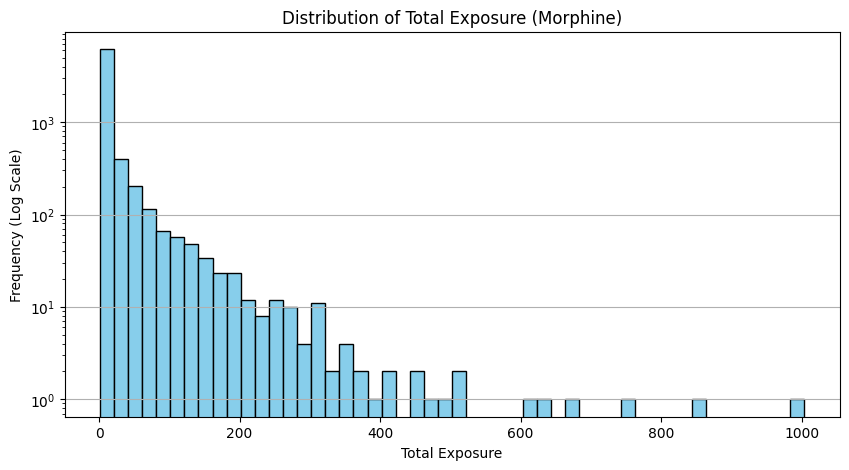

In [26]:
# Visualize total exposure counts
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count["total_exposure_counts"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Total Exposure (Morphine)")
plt.xlabel("Total Exposure")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig("distribution_total_exposure_morphine.svg", dpi=300, bbox_inches="tight")

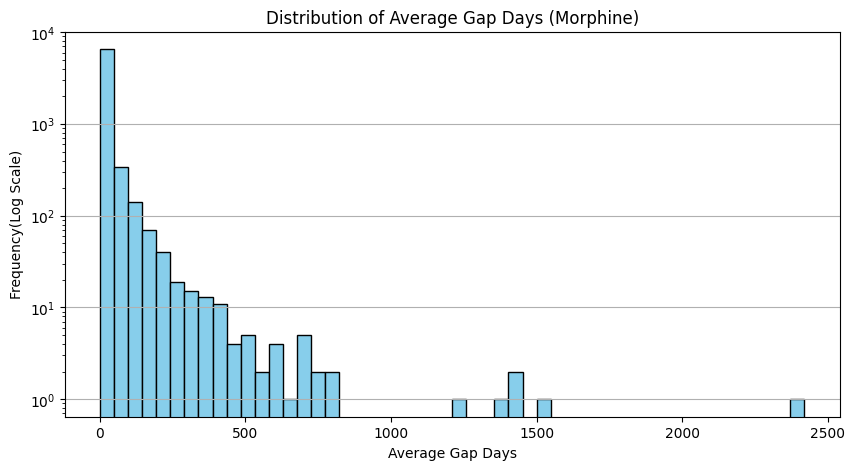

In [27]:
# Visualize average gap days
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count["average_gap_days"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Average Gap Days (Morphine)")
plt.xlabel("Average Gap Days")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig("distribution_average_gap_days_morphine.svg", dpi=300, bbox_inches="tight")
plt.show()

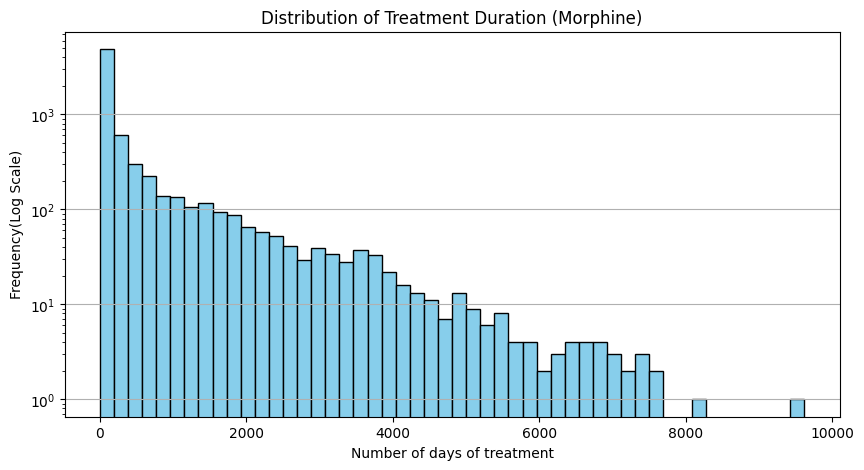

In [28]:
# Visualize treatment duration
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count["total_duration"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Treatment Duration (Morphine)")
plt.xlabel("Number of days of treatment")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig(
    "distribution_treatment_duration_morphine.svg", dpi=300, bbox_inches="tight"
)
plt.show()

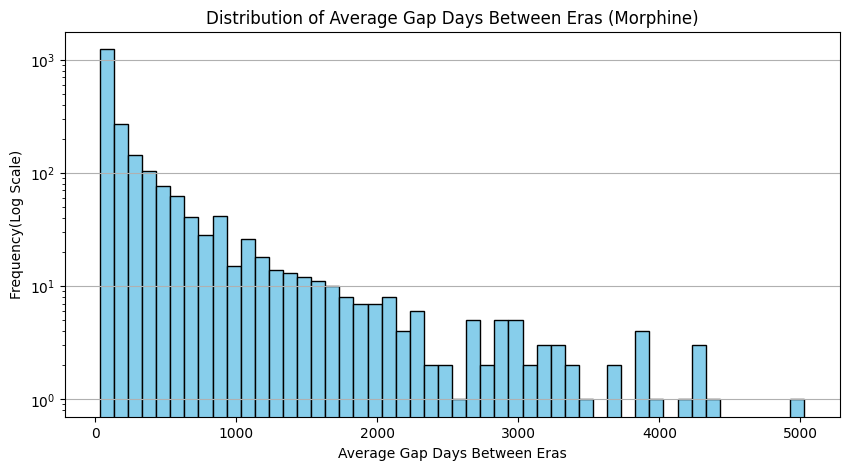

In [29]:
# Visualize average gap days
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count["average_gap_days_between_eras"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Average Gap Days Between Eras (Morphine)")
plt.xlabel("Average Gap Days Between Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig("distribution_average_gap_days_between_eras_morphine.svg", dpi=300, bbox_inches="tight")
plt.show()

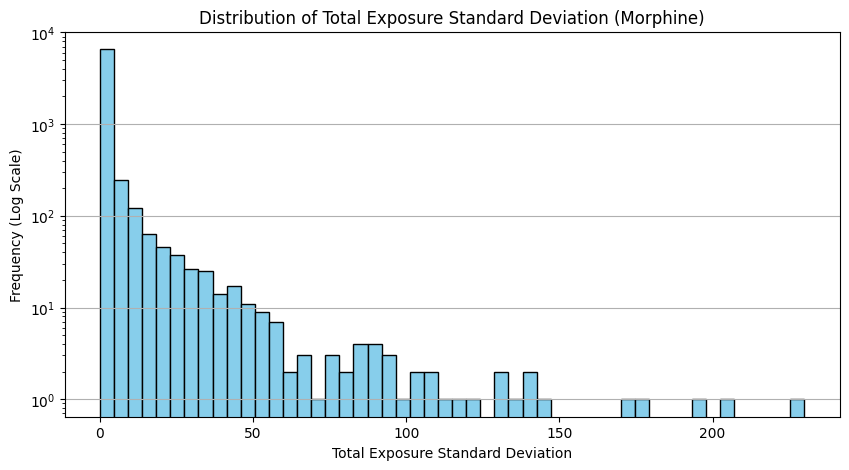

In [30]:
# Distribution of total exposure standard deviation
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count["exposure_counts_std"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Total Exposure Standard Deviation (Morphine)")
plt.xlabel("Total Exposure Standard Deviation")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.savefig(
    "distribution_total_exposure_std_morphine.svg", dpi=300, bbox_inches="tight"
)
plt.show()

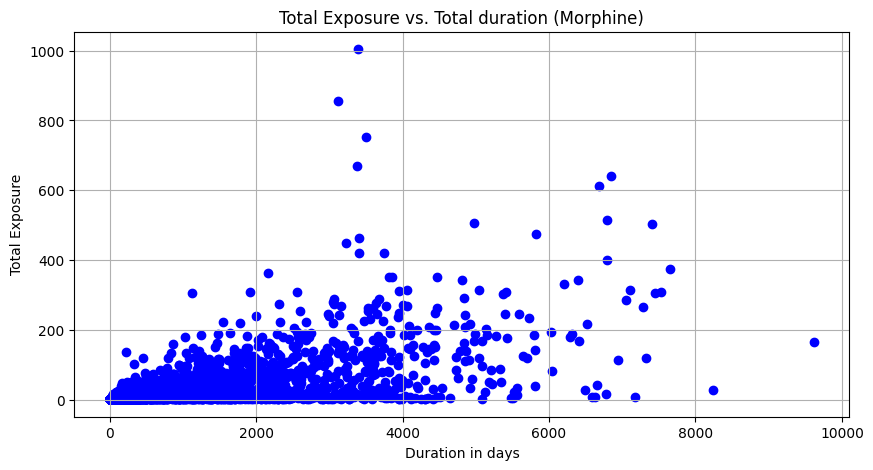


Correlation between total_duration and total_exposure_counts:
                       total_duration  total_exposure_counts
total_duration               1.000000               0.657772
total_exposure_counts        0.657772               1.000000


In [31]:
# Correlation between treatment duration and total exposure counts
plt.figure(figsize=(10, 5))
plt.scatter(
    morphine_eras_count["total_duration"],
    morphine_eras_count["total_exposure_counts"],
    c="blue",
)
plt.title("Total Exposure vs. Total duration (Morphine)")
plt.xlabel("Duration in days")
plt.ylabel("Total Exposure")
plt.grid()
# Save the plot as an image file
plt.savefig("total_exposure_vs_total_duration_morphine.svg", dpi=300, bbox_inches="tight")
plt.show()

# Insights
print("\nCorrelation between total_duration and total_exposure_counts:")
print(morphine_eras_count[["total_duration", "total_exposure_counts"]].corr())

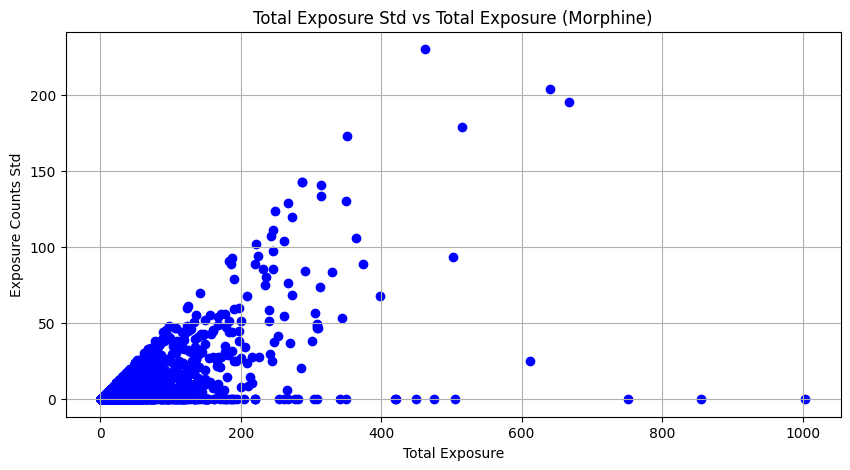

In [32]:
# Total exposure std vs total exposure
plt.figure(figsize=(10, 5))
plt.scatter(
    morphine_eras_count["total_exposure_counts"],
    morphine_eras_count["exposure_counts_std"],
    c="blue",
)
plt.title("Total Exposure Std vs Total Exposure (Morphine)")
plt.xlabel("Total Exposure")
plt.ylabel("Exposure Counts Std")
plt.grid()
plt.show()

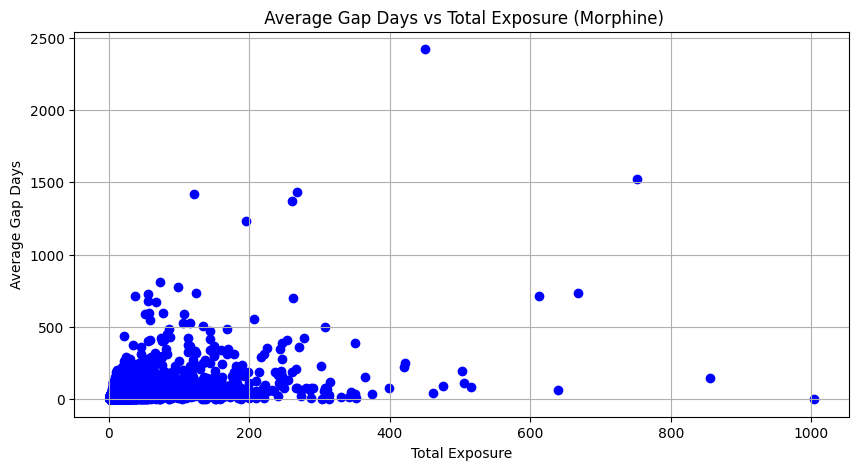

In [33]:
# Average gap vs Total exposure
plt.figure(figsize=(10, 5))
plt.scatter(
    morphine_eras_count["total_exposure_counts"],
    morphine_eras_count["average_gap_days"],
    c="blue",
)
plt.title(" Average Gap Days vs Total Exposure (Morphine)")
plt.xlabel("Total Exposure")
plt.ylabel("Average Gap Days")
plt.grid()
plt.show()

Now I will analyse fentanyl so later we can make eda of the people that take phentanyl and morphine

   gender  count
0  FEMALE   1009
1    MALE    675


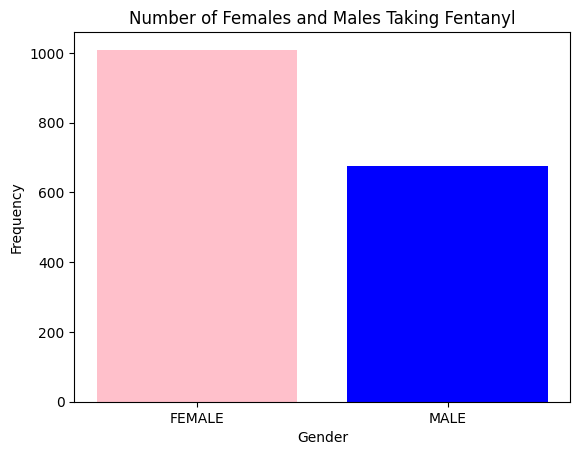

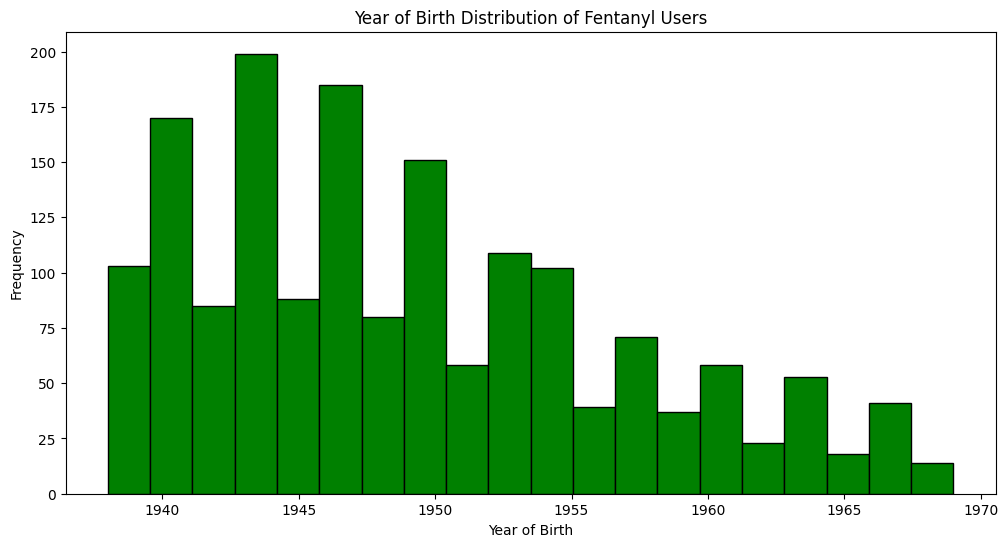

In [34]:
data_fentanyl = data[data["drug"] == "fentanyl"]
# Histogram of genders
eid_gender_counts = (
    data_fentanyl.groupby(["eid", "gender"]).size().reset_index(name="count")
)
gender_counts = eid_gender_counts.groupby("gender").size().reset_index(name="count")
print(gender_counts)
plt.bar(gender_counts["gender"], gender_counts["count"], color=["pink", "blue"])
plt.title("Number of Females and Males Taking Fentanyl")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.savefig("gender_histogram_fentanyl.png", dpi=300, bbox_inches="tight")
plt.show()
# Histogram of year of birth
eid_year_counts = (
    data_fentanyl.groupby(["eid", "year_of_birth"]).size().reset_index(name="count")
)
plt.figure(figsize=(12, 6))
plt.hist(eid_year_counts["year_of_birth"], bins=20, color="green", edgecolor="black")
plt.title("Year of Birth Distribution of Fentanyl Users")
plt.xlabel("Year of Birth")
plt.ylabel("Frequency")
plt.savefig("age_histogram_fentanyl.png", dpi=300, bbox_inches="tight")
plt.show()

In [35]:
data_fentanyl_sorted = data_fentanyl.sort_values(by="drug_era_start_date")
fentanyl_eras_count = (
    data_fentanyl_sorted.groupby("eid")
    .agg(
        num_drug_era_id=("drug_era_id", "nunique"),
        start_dates=("drug_era_start_date", list),
        end_dates=("drug_era_end_date", list),
        exposure_counts=("drug_exposure_count", list),
        gap_days=("gap_days", list),
    )
    .reset_index()
)
display(fentanyl_eras_count.drop("eid", axis=1))

,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days
0,1,"[2015-09-22, 2015-09-22]","[2016-05-14, 2016-05-14]","[16, 16]","[1, 1]"
1,1,"[2015-10-02, 2015-10-02]","[2015-10-31, 2015-10-31]","[1, 1]","[0, 0]"
2,1,"[2010-06-07, 2010-06-07]","[2010-07-20, 2010-07-20]","[2, 2]","[0, 0]"
3,1,"[2014-12-03, 2014-12-03]","[2015-01-01, 2015-01-01]","[1, 1]","[0, 0]"
4,2,"[2016-05-16, 2016-05-16, 2017-03-22, 2017-03-22]","[2016-07-26, 2016-07-26, 2017-04-20, 2017-04-20]","[8, 8, 2, 2]","[0, 0, 0, 0]"
...,...,...,...,...,...
1679,1,"[2011-08-09, 2011-08-09]","[2011-10-05, 2011-10-05]","[3, 3]","[0, 0]"
1680,3,"[2011-06-02, 2011-06-02, 2013-10-08, 2013-10-0...","[2011-07-08, 2011-07-08, 2014-01-17, 2014-01-1...","[3, 3, 5, 5, 2, 2]","[0, 0, 0, 0, 0, 0]"
1681,1,"[2011-03-10, 2011-03-10]","[2011-07-20, 2011-07-20]","[5, 5]","[33, 33]"
1682,1,"[2006-09-18, 2006-09-18]","[2007-01-13, 2007-01-13]","[5, 5]","[2, 2]"


In [36]:
def remove_duplicates(row):
    # Identify unique indices in start_dates
    seen = set()
    unique_indices = [i for i, x in enumerate(row["start_dates"]) if not (x in seen or seen.add(x))]
    
    # Filter each list column based on unique indices
    filtered_row = {
        "start_dates": [row["start_dates"][i] for i in unique_indices],
        "end_dates": [row["end_dates"][i] for i in unique_indices],
        "exposure_counts": [row["exposure_counts"][i] for i in unique_indices],
        "gap_days": [row["gap_days"][i] for i in unique_indices],
    }
    return filtered_row

# Apply the function row-wise
fentanyl_eras_count_remove_duplicates = fentanyl_eras_count.apply(remove_duplicates, axis=1)
# Reconstruct the DataFrame
fentanyl_eras_count["start_dates"] = fentanyl_eras_count_remove_duplicates.apply(lambda x: x["start_dates"])
fentanyl_eras_count["end_dates"] = fentanyl_eras_count_remove_duplicates.apply(lambda x: x["end_dates"])
fentanyl_eras_count["exposure_counts"] = fentanyl_eras_count_remove_duplicates.apply(lambda x: x["exposure_counts"])
fentanyl_eras_count["gap_days"] = fentanyl_eras_count_remove_duplicates.apply(lambda x: x["gap_days"])

display(fentanyl_eras_count.drop("eid", axis=1))

,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days
0,1,[2015-09-22],[2016-05-14],[16],[1]
1,1,[2015-10-02],[2015-10-31],[1],[0]
2,1,[2010-06-07],[2010-07-20],[2],[0]
3,1,[2014-12-03],[2015-01-01],[1],[0]
4,2,"[2016-05-16, 2017-03-22]","[2016-07-26, 2017-04-20]","[8, 2]","[0, 0]"
...,...,...,...,...,...
1679,1,[2011-08-09],[2011-10-05],[3],[0]
1680,3,"[2011-06-02, 2013-10-08, 2016-09-05]","[2011-07-08, 2014-01-17, 2016-10-15]","[3, 5, 2]","[0, 0, 0]"
1681,1,[2011-03-10],[2011-07-20],[5],[33]
1682,1,[2006-09-18],[2007-01-13],[5],[2]


Summary of num_drug_era_id:
count    1684.000000
mean        1.856888
std         2.549860
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        26.000000
Name: num_drug_era_id, dtype: float64

Summary of total exposure:
count    1684.000000
mean       21.938242
std        41.492703
min         1.000000
25%         2.000000
50%         5.000000
75%        19.250000
max       403.000000
Name: total_exposure_counts, dtype: float64

Summary of exposure counts std:
count    1684.000000
mean        2.855580
std         9.097113
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       105.875812
Name: exposure_counts_std, dtype: float64
Summary of total_duration:
count    1684.000000
mean      592.172803
std      1027.376617
min        29.000000
25%        29.000000
50%       106.500000
75%       601.250000
max      6763.000000
Name: total_duration, dtype: float64

Summary of average_gap_days:
count    1684.000000


/tmp/ipykernel_570/3367494601.py:46: RuntimeWarning: Mean of empty slice
  lambda x: np.nanmean(x)


,num_drug_era_id,start_dates,end_dates,exposure_counts,gap_days,total_exposure_counts,exposure_counts_std,start_dates_parsed,end_dates_parsed,total_duration,duration_era,gap_between_eras,average_gap_days,average_gap_days_between_eras
0,1,[2015-09-22],[2016-05-14],[16],[1],16,0.000000,"DatetimeIndex(['2015-09-22'], dtype='datetime6...","DatetimeIndex(['2016-05-14'], dtype='datetime6...",235,[235],[],1.0,NaN
1,1,[2015-10-02],[2015-10-31],[1],[0],1,0.000000,"DatetimeIndex(['2015-10-02'], dtype='datetime6...","DatetimeIndex(['2015-10-31'], dtype='datetime6...",29,[29],[],0.0,NaN
2,1,[2010-06-07],[2010-07-20],[2],[0],2,0.000000,"DatetimeIndex(['2010-06-07'], dtype='datetime6...","DatetimeIndex(['2010-07-20'], dtype='datetime6...",43,[43],[],0.0,NaN
3,1,[2014-12-03],[2015-01-01],[1],[0],1,0.000000,"DatetimeIndex(['2014-12-03'], dtype='datetime6...","DatetimeIndex(['2015-01-01'], dtype='datetime6...",29,[29],[],0.0,NaN
4,2,"[2016-05-16, 2017-03-22]","[2016-07-26, 2017-04-20]","[8, 2]","[0, 0]",10,3.000000,"DatetimeIndex(['2016-05-16', '2017-03-22'], dt...","DatetimeIndex(['2016-07-26', '2017-04-20'], dt...",339,"[71, 29]",[239],0.0,239.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,1,[2011-08-09],[2011-10-05],[3],[0],3,0.000000,"DatetimeIndex(['2011-08-09'], dtype='datetime6...","DatetimeIndex(['2011-10-05'], dtype='datetime6...",57,[57],[],0.0,NaN
1680,3,"[2011-06-02, 2013-10-08, 2016-09-05]","[2011-07-08, 2014-01-17, 2016-10-15]","[3, 5, 2]","[0, 0, 0]",10,1.247219,"DatetimeIndex(['2011-06-02', '2013-10-08', '20...","DatetimeIndex(['2011-07-08', '2014-01-17', '20...",1962,"[36, 101, 40]","[823, 962]",0.0,892.5
1681,1,[2011-03-10],[2011-07-20],[5],[33],5,0.000000,"DatetimeIndex(['2011-03-10'], dtype='datetime6...","DatetimeIndex(['2011-07-20'], dtype='datetime6...",132,[132],[],33.0,NaN
1682,1,[2006-09-18],[2007-01-13],[5],[2],5,0.000000,"DatetimeIndex(['2006-09-18'], dtype='datetime6...","DatetimeIndex(['2007-01-13'], dtype='datetime6...",117,[117],[],2.0,NaN


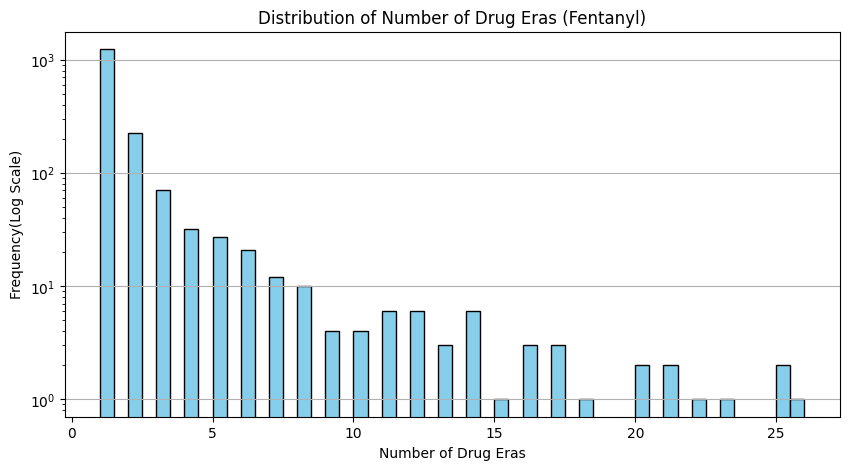

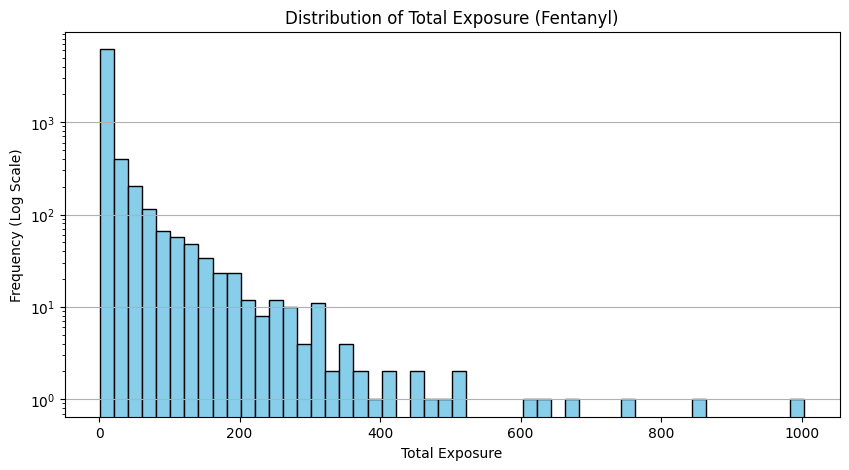

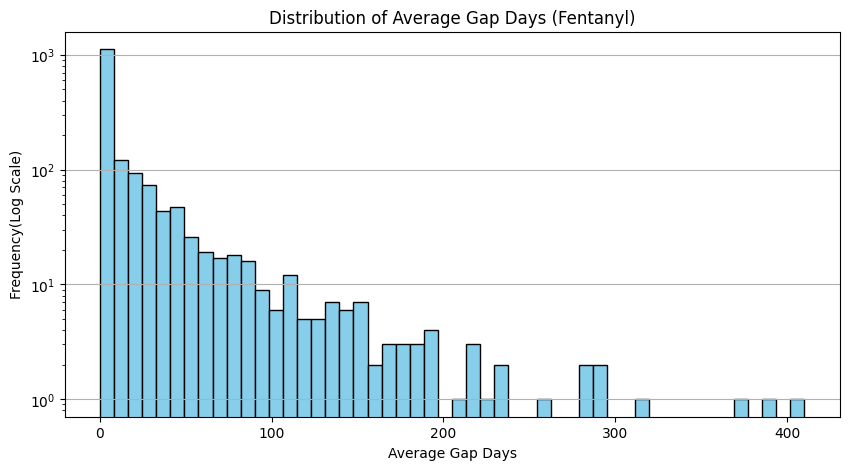

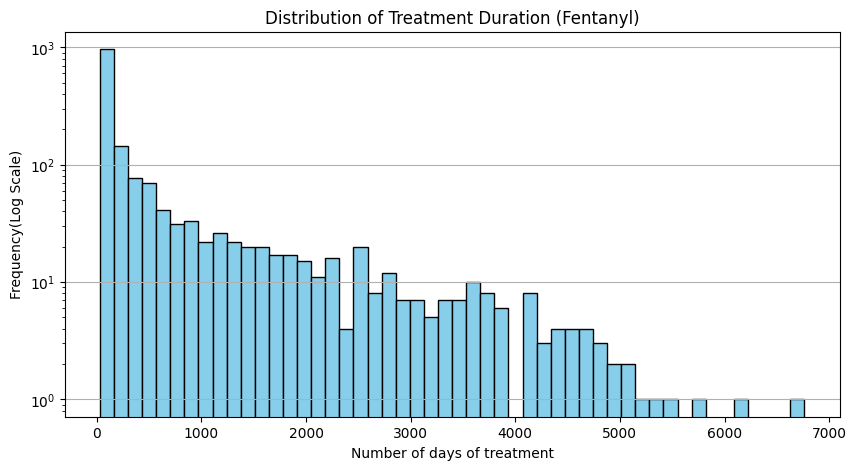

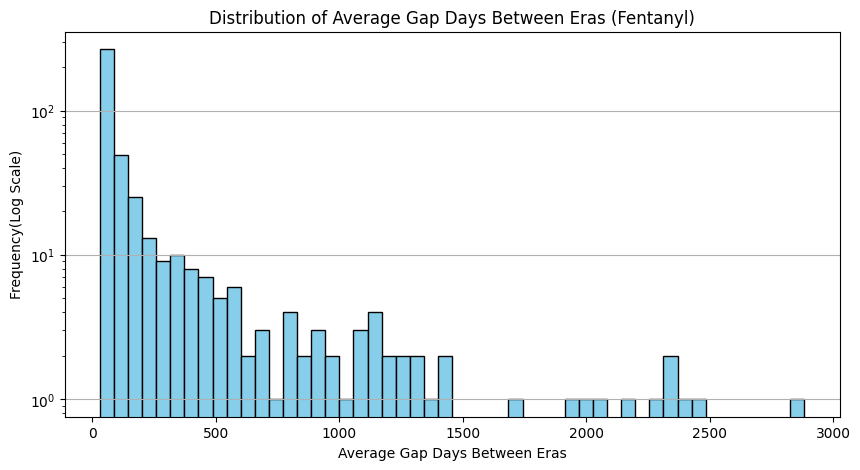

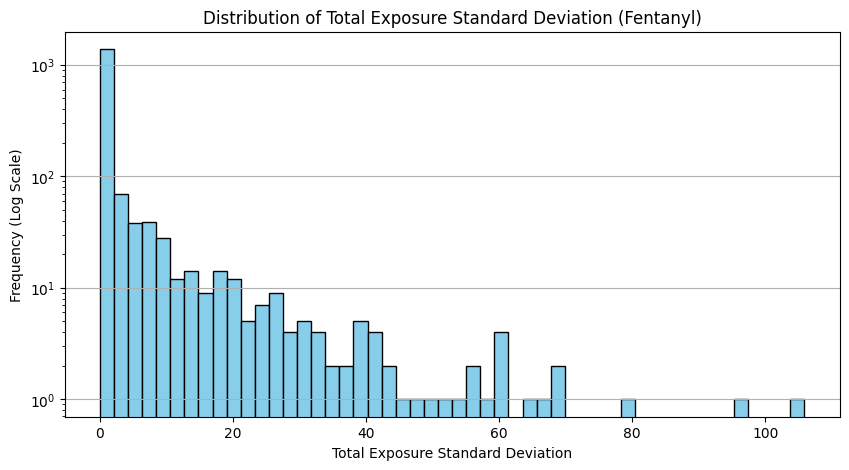

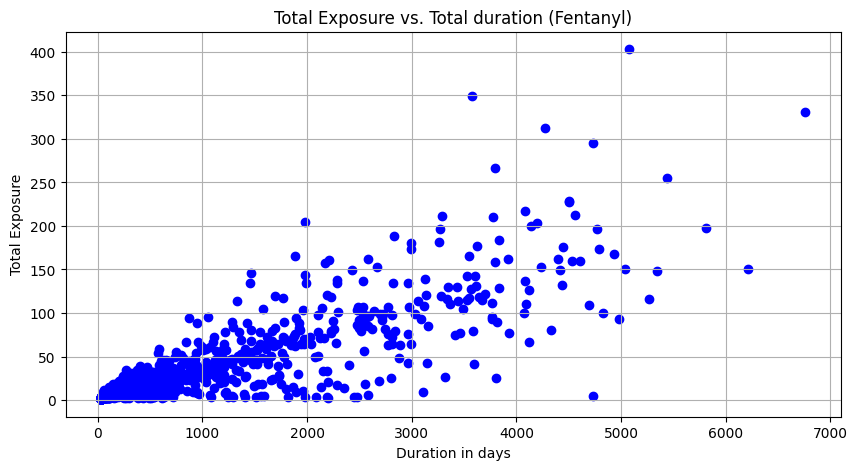


Correlation between total_duration and total_exposure_counts:
                       total_duration  total_exposure_counts
total_duration               1.000000               0.867522
total_exposure_counts        0.867522               1.000000


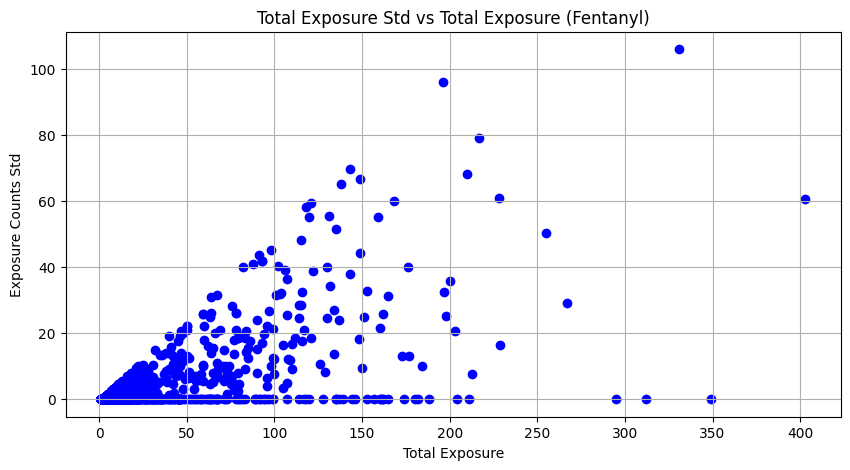

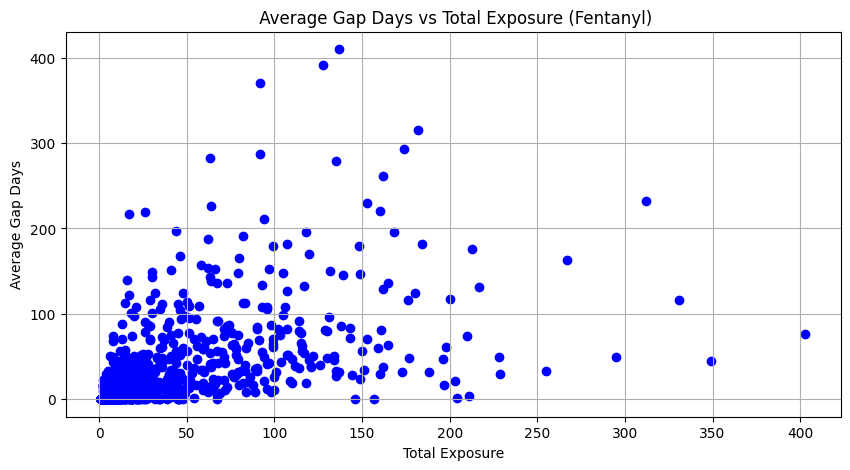

In [37]:
# Analyze num_drug_era_id
print("Summary of num_drug_era_id:")
print(fentanyl_eras_count["num_drug_era_id"].describe())

# Total exposures per participant
fentanyl_eras_count["total_exposure_counts"] = fentanyl_eras_count[
    "exposure_counts"
].apply(sum)
# Analyze total exposure counts
print("\nSummary of total exposure:")
print(fentanyl_eras_count["total_exposure_counts"].describe())

# Calculate the standard deviation of exposure_counts to assess variability:
fentanyl_eras_count["exposure_counts_std"] = fentanyl_eras_count[
    "exposure_counts"
].apply(lambda x: np.nanstd(x))
# Analyze total exposure counts
print("\nSummary of exposure counts std:")
print(fentanyl_eras_count["exposure_counts_std"].describe())

# Convert dates to datetime
fentanyl_eras_count['start_dates_parsed'] = fentanyl_eras_count['start_dates'].apply(lambda x: pd.to_datetime(x))
fentanyl_eras_count['end_dates_parsed'] = fentanyl_eras_count['end_dates'].apply(lambda x: pd.to_datetime(x))
# Calculate total_duration
fentanyl_eras_count['total_duration'] = fentanyl_eras_count.apply(lambda row: (max(row['end_dates_parsed']) - min(row['start_dates_parsed'])).days, axis=1)
print("Summary of total_duration:")
print(fentanyl_eras_count["total_duration"].describe())

# Calculate duration_era
fentanyl_eras_count['duration_era'] = fentanyl_eras_count.apply(lambda row: [(end - start).days for start, end in zip(row['start_dates_parsed'], row['end_dates_parsed'])], axis=1)

# Calculate gap_between_eras
fentanyl_eras_count['gap_between_eras'] = fentanyl_eras_count.apply(
    lambda row: [(next_start - prev_end).days for prev_end, next_start in zip(row['end_dates_parsed'][:-1], row['start_dates_parsed'][1:])], 
    axis=1
)
# Average gap days per participant (ignoring NaN gaps)
fentanyl_eras_count["average_gap_days"] = fentanyl_eras_count["gap_days"].apply(
    lambda x: np.nanmean(x)
)  # Exclude NaN
print("\nSummary of average_gap_days:")
print(fentanyl_eras_count["average_gap_days"].describe())

# Average gap days between eras per participant (ignoring NaN gaps)
fentanyl_eras_count["average_gap_days_between_eras"] = fentanyl_eras_count["gap_between_eras"].apply(
    lambda x: np.nanmean(x)
)  # Exclude NaN
print("\nSummary of average_gap_days_between_eras:")
print(fentanyl_eras_count["average_gap_days_between_eras"].describe())

display(fentanyl_eras_count.drop("eid", axis=1))
# Visualize num_drug_era_id
plt.figure(figsize=(10, 5))
plt.hist(
    fentanyl_eras_count["num_drug_era_id"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Number of Drug Eras (Fentanyl)")
plt.xlabel("Number of Drug Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.savefig("distribution_number_eras_fentanyl.svg", dpi=300, bbox_inches="tight")
plt.show()
# Visualize total exposure counts
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count["total_exposure_counts"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Distribution of Total Exposure (Fentanyl)")
plt.xlabel("Total Exposure")
plt.ylabel("Frequency (Log Scale)")
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig("distribution_total_exposure_fentanyl.svg", dpi=300, bbox_inches="tight")
plt.show()

# Visualize average gap days
plt.figure(figsize=(10, 5))
plt.hist(
    fentanyl_eras_count["average_gap_days"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Average Gap Days (Fentanyl)")
plt.xlabel("Average Gap Days")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig("distribution_average_gap_days_fentanyl.svg", dpi=300, bbox_inches="tight")
plt.show()
# Visualize treatment duration
plt.figure(figsize=(10, 5))
plt.hist(
    fentanyl_eras_count["total_duration"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Treatment Duration (Fentanyl)")
plt.xlabel("Number of days of treatment")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig(
    "distribution_treatment_duration_fentanyl.svg", dpi=300, bbox_inches="tight"
)
plt.show()
# Visualize average gap days
plt.figure(figsize=(10, 5))
plt.hist(
    fentanyl_eras_count["average_gap_days_between_eras"].dropna(),
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Average Gap Days Between Eras (Fentanyl)")
plt.xlabel("Average Gap Days Between Eras")
plt.ylabel("Frequency(Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig("distribution_average_gap_days_between_eras_fentanyl.svg", dpi=300, bbox_inches="tight")
plt.show()
# Distribution of total exposure standard deviation
plt.figure(figsize=(10, 5))
plt.hist(
    fentanyl_eras_count["exposure_counts_std"],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Total Exposure Standard Deviation (Fentanyl)")
plt.xlabel("Total Exposure Standard Deviation")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
plt.show()

# Correlation between treatment duration and total exposure counts
plt.figure(figsize=(10, 5))
plt.scatter(
    fentanyl_eras_count["total_duration"],
    fentanyl_eras_count["total_exposure_counts"],
    c="blue",
)
plt.title("Total Exposure vs. Total duration (Fentanyl)")
plt.xlabel("Duration in days")
plt.ylabel("Total Exposure")
plt.grid()
# Save the plot as an image file
plt.savefig("total_exposure_vs_total_duration_fentanyl.svg", dpi=300, bbox_inches="tight")
plt.show()

# Insights
print("\nCorrelation between total_duration and total_exposure_counts:")
print(fentanyl_eras_count[["total_duration", "total_exposure_counts"]].corr())

# Total exposure std vs total exposure
plt.figure(figsize=(10, 5))
plt.scatter(
    fentanyl_eras_count["total_exposure_counts"],
    fentanyl_eras_count["exposure_counts_std"],
    c="blue",
)
plt.title("Total Exposure Std vs Total Exposure (Fentanyl)")
plt.xlabel("Total Exposure")
plt.ylabel("Exposure Counts Std")
plt.grid()
plt.show()
# Average gap vs Total exposure
plt.figure(figsize=(10, 5))
plt.scatter(
    fentanyl_eras_count["total_exposure_counts"],
    fentanyl_eras_count["average_gap_days"],
    c="blue",
)
plt.title(" Average Gap Days vs Total Exposure (Fentanyl)")
plt.xlabel("Total Exposure")
plt.ylabel("Average Gap Days")
plt.grid()
plt.show()

How to do Adherence Study: 
Instead of relying on start_dates and end_dates (mostly null), we can use:

a. Treatment duration (total_duration): Participants with longer treatments may suggest more adherence .

b. Total Exposure Counts (total_exposure_counts): Higher values may correlate with adherence, as consistent exposure counts indicate continued drug usage.

c. Average Gap Days (average_gap_days):Smaller gaps between drug exposures suggest adherence, while larger or inconsistent gaps indicate non-adherence.

d. Average Gap Days between Eras (average_gap_days_between_eras):  Smaller gaps between drug exposures suggest adherence

Calculate a score: df['total_duration'] = (
    df['total_exposure_counts'] -  # Higher exposure counts are better
    (df['average_gap_days']) -  # Smaller gaps are better
    (df['average_gap_days_between_eras'])  # Lower variability is better
)

Summary of adherence_score with more than 1 exposure:
count    2214.000000
mean        1.044578
std         2.192649
min        -4.402909
25%         0.012708
50%         0.310605
75%         1.353129
max        20.160724
Name: adherence_score_omop, dtype: float64


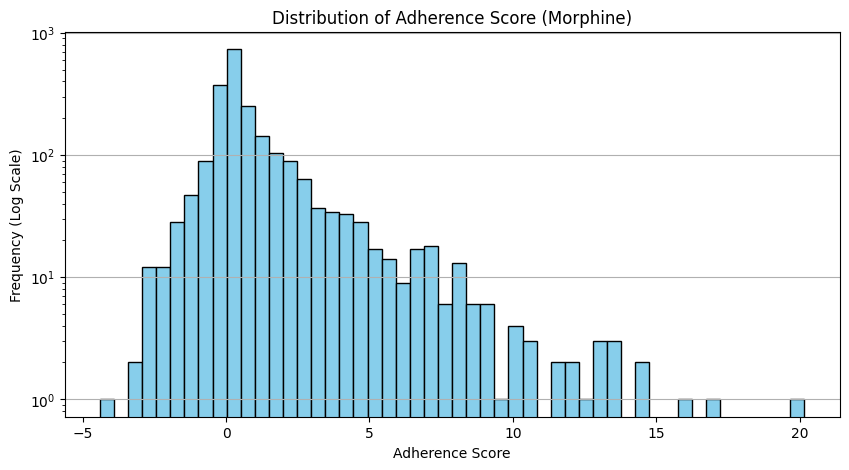

In [38]:
# Include adherence score for Morphine normalizing each feature:
# Initialize the scaler
scaler = StandardScaler()
morphine_eras_count["adherence_score_omop"] = (
    scaler.fit_transform(
        morphine_eras_count["total_duration"].values.reshape(-1, 1)
    )  
    + scaler.fit_transform(
        morphine_eras_count["total_exposure_counts"].values.reshape(-1, 1)
    )  # Higher exposure counts are better
    - scaler.fit_transform(
        (morphine_eras_count["average_gap_days"].values.reshape(-1, 1))
    )  # Smaller gaps are better
    - scaler.fit_transform(
        (morphine_eras_count["average_gap_days_between_eras"].values.reshape(-1, 1))
    )  # Lower variability is better
)
print("Summary of adherence_score with more than 1 exposure:")
print(morphine_eras_count[morphine_eras_count["total_exposure_counts"] > 1]["adherence_score_omop"].describe())

# Distribution of adherence score for people with more than 1 exposure
plt.figure(figsize=(10, 5))
plt.hist(
    morphine_eras_count[morphine_eras_count["total_exposure_counts"] > 1][
        "adherence_score_omop"
    ],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Adherence Score (Morphine)")
plt.xlabel("Adherence Score")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig("distribution_adherence_score_morphine.svg", dpi=300, bbox_inches="tight")
plt.show()

Summary of adherence_score with more than 1 exposure:
count    443.000000
mean       1.313921
std        2.271977
min       -3.762112
25%       -0.057565
50%        0.555166
75%        2.362782
max       12.440881
Name: adherence_score_omop, dtype: float64


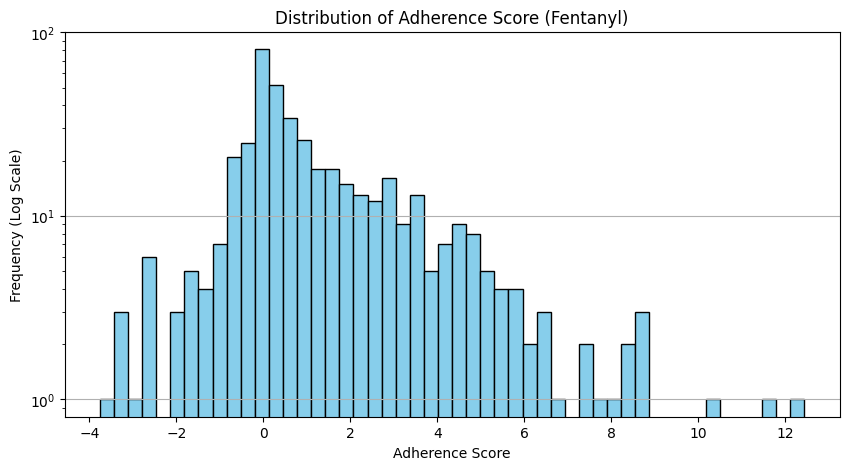

In [39]:
# Include adherence score for Fentanyl normalizing each feature:
# Initialize the scaler
scaler = StandardScaler()
fentanyl_eras_count["adherence_score_omop"] = (
    scaler.fit_transform(
        fentanyl_eras_count["total_duration"].values.reshape(-1, 1)
    )  
    + scaler.fit_transform(
        fentanyl_eras_count["total_exposure_counts"].values.reshape(-1, 1)
    )  # Higher exposure counts are better
    - scaler.fit_transform(
        (fentanyl_eras_count["average_gap_days"].values.reshape(-1, 1))
    )  # Smaller gaps are better
    - scaler.fit_transform(
        (fentanyl_eras_count["average_gap_days_between_eras"].values.reshape(-1, 1))
    )  # Lower variability is better
)
print("Summary of adherence_score with more than 1 exposure:")
print(fentanyl_eras_count[fentanyl_eras_count["total_exposure_counts"] > 1]["adherence_score_omop"].describe())

# Distribution of adherence score for people with more than 1 exposure
plt.figure(figsize=(10, 5))
plt.hist(
    fentanyl_eras_count[fentanyl_eras_count["total_exposure_counts"] > 1][
        "adherence_score_omop"
    ],
    bins=50,
    color="skyblue",
    edgecolor="black",
)
plt.title("Distribution of Adherence Score (Fentanyl)")
plt.xlabel("Adherence Score")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.grid(axis="y")
# Save the plot as an image file
plt.savefig("distribution_adherence_score_fentanyl.svg", dpi=300, bbox_inches="tight")

In [40]:
fentanyl_eras_count.to_csv("omop_fentanyl_groupbyeid.csv", index=False)
morphine_eras_count.to_csv("omop_morphine_groupbyeid.csv", index=False)

## EDA drug switch morphine - fentanyl

In [70]:
morphine_df =  morphine_eras_count
fentanyl_df = fentanyl_eras_count

# Identify EIDs
morphine_eids = set(morphine_df["eid"])
fentanyl_eids = set(fentanyl_df["eid"])

# EIDs for the three categories
only_morphine_eids = morphine_eids - fentanyl_eids
only_fentanyl_eids = fentanyl_eids - morphine_eids
both_eids = morphine_eids & fentanyl_eids

# Print the number of common and distinct 'eid' values
print(f"Number of common eids: {len(both_eids)}")
print(f"Number of eids only in morphine: {len(only_morphine_eids)}")
print(f"Number of eids only in fentanyl: {len(only_fentanyl_eids)}")

# Create DataFrames for only morphine and only fentanyl
only_morphine_df = morphine_df[morphine_df["eid"].isin(only_morphine_eids)]
only_fentanyl_df = fentanyl_df[fentanyl_df["eid"].isin(only_fentanyl_eids)]

# Combine rows for EIDs present in both
both_rows = []
for eid in both_eids:
    morphine_rows = morphine_df[morphine_df["eid"] == eid]
    fentanyl_rows = fentanyl_df[fentanyl_df["eid"] == eid]
    
    # Concatenate and sort by start_dates
    combined = pd.concat([morphine_rows, fentanyl_rows], keys=["morphine", "fentanyl"])
    combined = combined.sort_values(by="start_dates")
    
    # Create a new column identifying the drug
    combined["drug_type"] = combined.index.get_level_values(0)
    
    # Append to results
    both_rows.append(combined)

# Combine all rows into a single DataFrame for EIDs present in both
both_df = pd.concat(both_rows)

# Select only the desired columns for the final DataFrames
columns_to_keep = [
    "eid", "num_drug_era_id", "start_dates", "end_dates", "exposure_counts",
    "gap_days", "total_exposure_counts", "total_duration",
    "duration_era", "gap_between_eras", "drug_type"
]

only_morphine_df = only_morphine_df[columns_to_keep[:-1]]  # No `drug_type` for these
only_fentanyl_df = only_fentanyl_df[columns_to_keep[:-1]]
both_df = both_df[columns_to_keep]
display(both_df.drop("eid", axis=1))

Number of common eids: 977
Number of eids only in morphine: 6240
Number of eids only in fentanyl: 707


num_drug_era_id  \
fentanyl 98                  4   
morphine 435                 1   
fentanyl 1207                2   
morphine 5263                1   
fentanyl 1030                1   
...                        ...   
         1360                1   
morphine 2273                4   
fentanyl 492                 1   
         944                 1   
morphine 4110                1   

                                                    start_dates  \
fentanyl 98    [2003-12-05, 2004-02-05, 2004-10-06, 2013-11-26]   
morphine 435                                       [2011-08-01]   
fentanyl 1207                          [2010-07-23, 2011-02-21]   
morphine 5263                                      [2011-01-26]   
fentanyl 1030                                      [2010-11-08]   
...                                                         ...   
         1360                                      [2014-09-24]   
morphine 2273  [2011-11-30, 2012-03-20, 2012-08-07, 2013-03-01]   
fentanyl 492                                       [2013-12-30]   
         944                                       [2007-07-26]   
morphine 4110                                      [2014-09-08]   

                                                      end_dates  \
fentanyl 98    [2004-01-03, 2004-03-05, 2013-10-25, 2013-12-25]   
morphine 435                                       [2011-08-30]   
fentanyl 1207                          [2010-12-28, 2011-04-16]   
morphine 5263                                      [2011-02-24]   
fentanyl 1030                                      [2011-09-07]   
...                                                         ...   
         1360                                      [2015-11-04]   
morphine 2273  [2012-02-04, 2012-05-16, 2012-09-05, 2013-05-11]   
fentanyl 492                                       [2014-01-28]   
         944                                       [2008-01-03]   
morphine 4110                                      [2014-09-13]   

              exposure_counts         gap_days  total_exposure_counts  \
fentanyl 98    [1, 1, 112, 1]   [0, 0, 265, 0]                    115   
morphine 435              [1]              [0]                      1   
fentanyl 1207          [7, 3]          [14, 0]                     10   
morphine 5263             [1]              [0]                      1   
fentanyl 1030            [14]             [25]                     14   
...                       ...              ...                    ...   
         1360            [37]             [19]                     37   
morphine 2273    [4, 3, 1, 4]  [22, 17, 0, 13]                     12   
fentanyl 492              [1]              [0]                      1   
         944              [5]             [17]                      5   
morphine 4110             [1]              [0]                      1   

               total_duration        duration_era gap_between_eras drug_type  
fentanyl 98              3673  [29, 29, 3306, 29]    [33, 215, 32]  fentanyl  
morphine 435               29                [29]               []  morphine  
fentanyl 1207             267           [158, 54]             [55]  fentanyl  
morphine 5263              29                [29]               []  morphine  
fentanyl 1030             303               [303]               []  fentanyl  
...                       ...                 ...              ...       ...  
         1360             406               [406]               []  fentanyl  
morphine 2273             528    [66, 57, 29, 71]    [45, 83, 177]  morphine  
fentanyl 492               29                [29]               []  fentanyl  
         944              161               [161]               []  fentanyl  
morphine 4110               5                 [5]               []  morphine  

[1954 rows x 10 columns]

Now we can study drug switching:

In [115]:
# Convert 'start_dates' and 'end_dates' to datetime
def convert_dates(date_list):
    return pd.to_datetime(date_list)

# Convert start_dates and end_dates for each row in morphine_filtered and fentanyl_filtered
morphine_df['start_dates'] = morphine_df['start_dates'].apply(convert_dates)
fentanyl_df['start_dates'] = fentanyl_df['start_dates'].apply(convert_dates)# Initialize counters

morphine_to_fentanyl = 0
fentanyl_to_morphine = 0

# Analyze switches
for eid in both_eids:
    morphine_dates = morphine_df[morphine_df["eid"] == eid]["start_dates"].explode().sort_values()
    fentanyl_dates = fentanyl_df[fentanyl_df["eid"] == eid]["start_dates"].explode().sort_values()

    # Compare the earliest dates for each drug
    if morphine_dates.iloc[0] < fentanyl_dates.iloc[0]:
        morphine_to_fentanyl += 1
    else:
        fentanyl_to_morphine += 1

print(f"People switching from morphine to fentanyl: {morphine_to_fentanyl}")
print(f"People switching from fentanyl to morphine: {fentanyl_to_morphine}")


# Initialize list to store the results
switches_list = []
# Initialize counter for multiple switches
multiple_switches_count = 0

# Analyze switches for each eid
for eid in both_eids:
    # Get start dates for both drugs
    morphine_dates = morphine_df[morphine_df["eid"] == eid]["start_dates_parsed"].explode().sort_values()
    fentanyl_dates = fentanyl_df[fentanyl_df["eid"] == eid]["start_dates_parsed"].explode().sort_values()

    # Merge and sort all start dates with drug type
    combined = pd.concat([ 
        pd.DataFrame({"date": morphine_dates, "drug": "morphine"}), 
        pd.DataFrame({"date": fentanyl_dates, "drug": "fentanyl"}) 
    ]).sort_values(by="date")

    # Track the order of drug switches
    switches = []
    previous_drug = None
    switch_count = 0

    for _, row in combined.iterrows():
        current_drug = row["drug"]
        if current_drug != previous_drug:
            if previous_drug is not None:  # Ignore the first entry
                switch_count += 1
            switches.append(current_drug)
            previous_drug = current_drug

    # Store results only for multiple switches
    if switch_count > 1:
        switches_list.append({
            "eid": eid,
            "number_of_switches": switch_count,
            "switches": switches
        })
        multiple_switches_count += 1

# Convert the list of results to a DataFrame
switches_df = pd.DataFrame(switches_list)

# Output results
print(f"Total people who switched more than once: {multiple_switches_count}")
# Output the resulting DataFrame
display(switches_df.drop("eid", axis=1))

People switching from morphine to fentanyl: 563
People switching from fentanyl to morphine: 414
Total people who switched more than once: 294


,number_of_switches,switches
0,2,"[fentanyl, morphine, fentanyl]"
1,2,"[fentanyl, morphine, fentanyl]"
2,3,"[morphine, fentanyl, morphine, fentanyl]"
3,2,"[fentanyl, morphine, fentanyl]"
4,2,"[morphine, fentanyl, morphine]"
...,...,...
289,4,"[fentanyl, morphine, fentanyl, morphine, fenta..."
290,2,"[morphine, fentanyl, morphine]"
291,4,"[morphine, fentanyl, morphine, fentanyl, morph..."
292,5,"[morphine, fentanyl, morphine, fentanyl, morph..."


And make some eda figures:

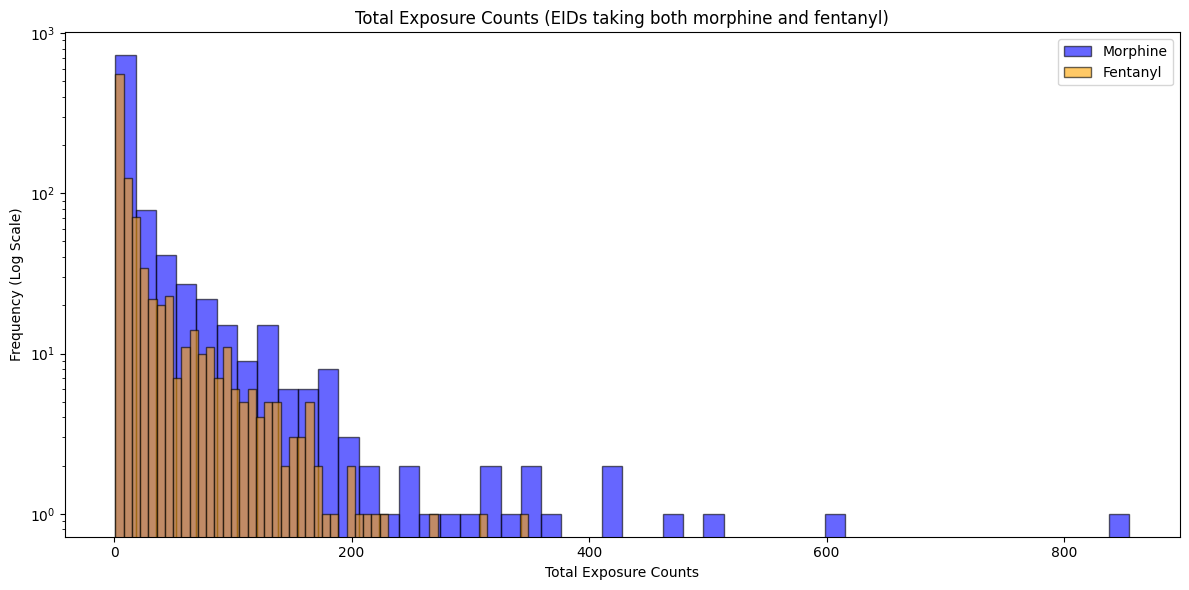

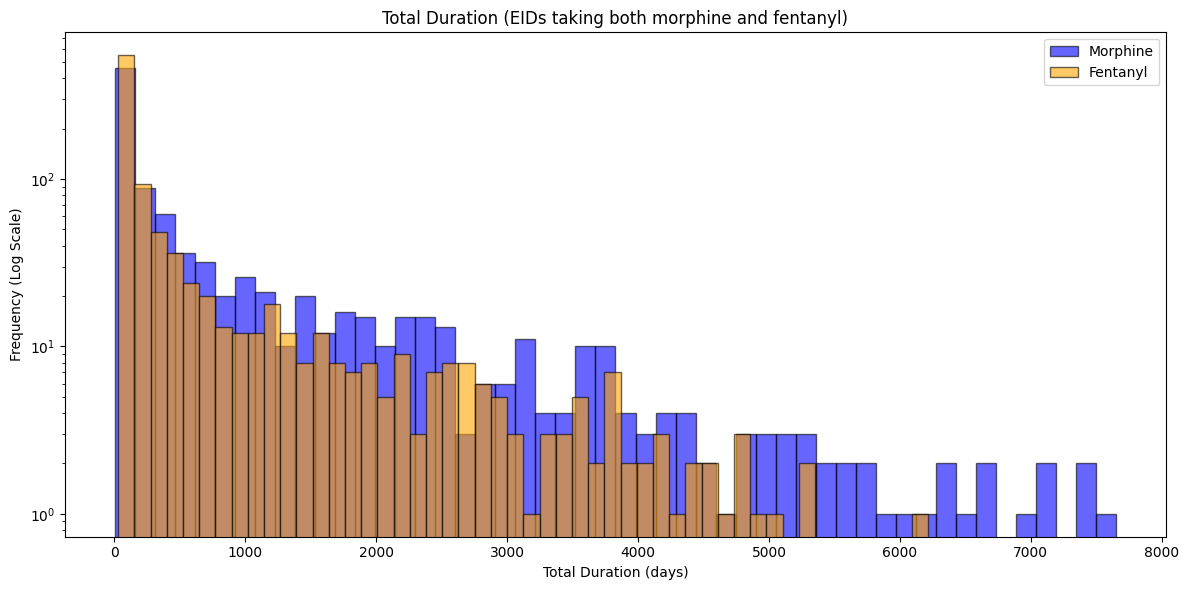

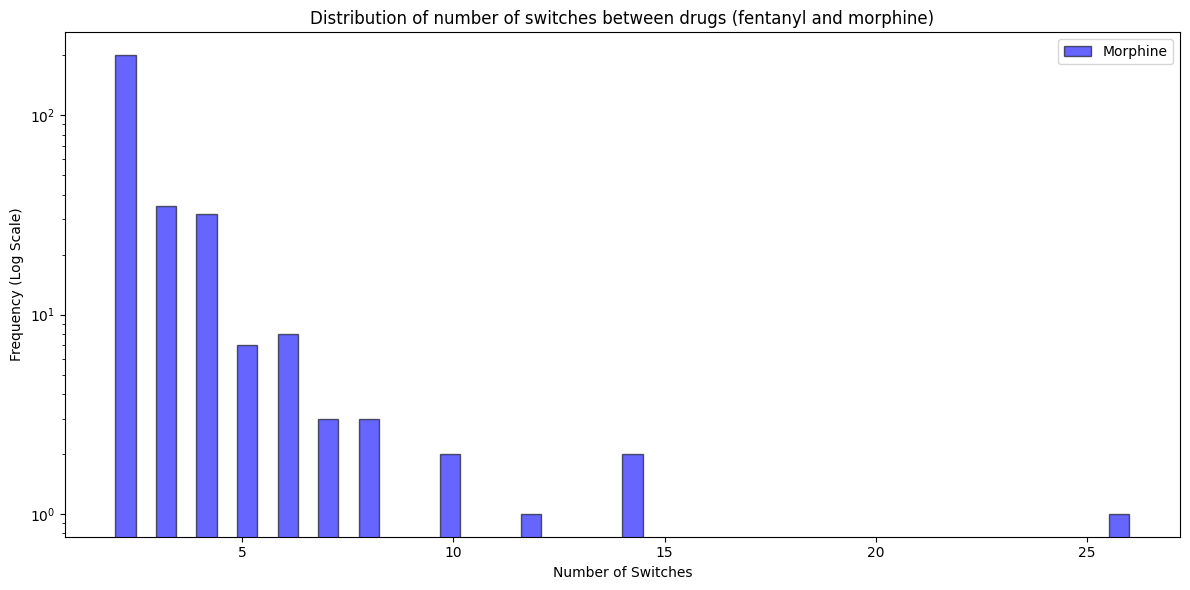

In [117]:
# Separate by drug type
morphine_df_from_both = both_df[both_df["drug_type"] == "morphine"]
fentanyl_df_from_both = both_df[both_df["drug_type"] == "fentanyl"]

# Plot histograms for total_exposure_counts
plt.figure(figsize=(12, 6))
plt.hist(
    morphine_df_from_both["total_exposure_counts"], bins=50, alpha=0.6, color="blue", edgecolor="black", label="Morphine"
)
plt.hist(
    fentanyl_df_from_both["total_exposure_counts"], bins=50, alpha=0.6, color="orange", edgecolor="black", label="Fentanyl"
)
plt.title("Total Exposure Counts (EIDs taking both morphine and fentanyl)")
plt.xlabel("Total Exposure Counts")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.legend()
plt.tight_layout()
plt.show()

# Plot histograms for total_duration
plt.figure(figsize=(12, 6))
plt.hist(
    morphine_df_from_both["total_duration"], bins=50, alpha=0.6, color="blue", edgecolor="black", label="Morphine"
)
plt.hist(
    fentanyl_df_from_both["total_duration"], bins=50, alpha=0.6, color="orange", edgecolor="black", label="Fentanyl"
)
plt.title("Total Duration (EIDs taking both morphine and fentanyl)")
plt.xlabel("Total Duration (days)")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.legend()
plt.tight_layout()
plt.show()

# Plot histograms for switches
plt.figure(figsize=(12, 6))
plt.hist(
    switches_df["number_of_switches"], bins=50, alpha=0.6, color="blue", edgecolor="black", label="Morphine"
)
plt.title("Distribution of number of switches between drugs (fentanyl and morphine)")
plt.xlabel("Number of Switches")
plt.ylabel("Frequency (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.legend()
plt.tight_layout()
plt.show()

In [118]:
only_morphine_df.to_csv("only_morphine.csv", index=False)
only_fentanyl_df.to_csv("only_fentanyl.csv", index=False)
both_df.to_csv("both_morphine_fentanyl.csv", index=False)
switches_df.to_csv("switches_morphine_fentanyl.csv", index=False)

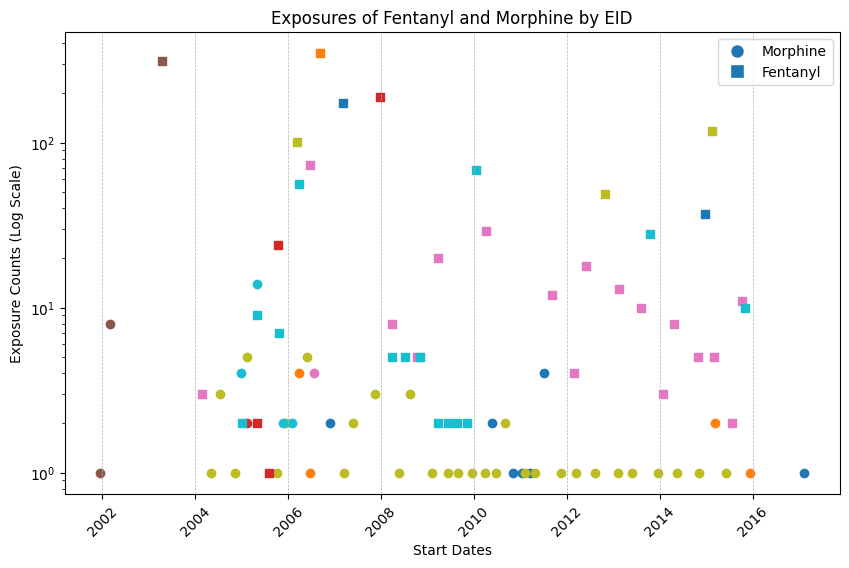

In [119]:
# Step 1: Filter morphine_df_from_both by total_exposure_counts
morphine_filtered = morphine_df_from_both[morphine_df_from_both['total_exposure_counts'] > 1]
# Step 2: Extract eids from the filtered morphine dataframe
eids_morphine_filtered = morphine_filtered['eid']
# Step 3: Filter fentanyl_df_from_both for eids that are in the filtered morphine dataframe
fentanyl_filtered = fentanyl_df_from_both[fentanyl_df_from_both['eid'].isin(eids_morphine_filtered)]
# Step 4: Filter fentanyl_df_from_both by total_exposure_counts 
fentanyl_filtered = fentanyl_filtered[fentanyl_filtered['total_exposure_counts'] > 200]
# Step 5: Extract eids from the filtered fentanyl dataframe
eids_fentanyl_filtered = fentanyl_filtered['eid']
# Step 6: Filter morphine_filtered for eids that are in the filtered fentanyl dataframe
morphine_filtered = morphine_filtered[morphine_filtered['eid'].isin(eids_fentanyl_filtered)]

# Convert start_dates and end_dates for each row in morphine_filtered and fentanyl_filtered
morphine_filtered['start_dates'] = morphine_filtered['start_dates'].apply(convert_dates)
fentanyl_filtered['start_dates'] = fentanyl_filtered['start_dates'].apply(convert_dates)

# Plot setup
plt.figure(figsize=(10, 6))

# Initialize empty lists to store legend handles and labels
legend_handles = []
legend_labels = []

# Generate a colormap with enough colors for all unique eids
unique_eids = morphine_filtered.index  # Assuming eid is the index
colors = cm.get_cmap("tab10", len(unique_eids))

# Loop through each row and plot for morphine
for i, (eid, row) in enumerate(morphine_filtered.iterrows()):
    # Sort the data by issue_dates to ensure lines are properly connected
    sorted_dates, sorted_exposures = zip(*sorted(zip(row["start_dates"], row["exposure_counts"])))
    # Plot the line connecting points for this eid
    plt.scatter(sorted_dates, sorted_exposures, marker='o', color=colors(i))

# Add legend handle for morphine (circle marker)
legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors(0), markersize=10))
legend_labels.append('Morphine')

# Loop through each row and plot for fentanyl
for i, (eid, row) in enumerate(fentanyl_filtered.iterrows()):
    # Sort the data by issue_dates to ensure lines are properly connected
    sorted_dates, sorted_exposures = zip(*sorted(zip(row["start_dates"], row["exposure_counts"])))
    # Plot the line connecting points for this eid
    plt.scatter(sorted_dates, sorted_exposures, marker='s', color=colors(i))

# Add legend handle for fentanyl (x marker)
legend_handles.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors(0), markersize=10))
legend_labels.append('Fentanyl')

# Add labels, title, and legend
plt.xlabel("Start Dates")
plt.ylabel("Exposure Counts (Log Scale)")
plt.yscale("log")  # Logarithmic scale for y-axis
plt.title("Exposures of Fentanyl and Morphine by EID")
plt.xticks(rotation=45)

# Add legend using the handles and labels created above
plt.legend(handles=legend_handles, labels=legend_labels, loc='best')

# Optionally, add a grid to better view the timeline
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

